In [ ]:
import warnings 
warnings.filterwarnings('ignore')

from pathlib import Path
root = Path.cwd()

import pandas as pd

from osgeo import gdal

# GDAL configurations used to access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
#gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')

gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','.tif, .tiff')


import earthaccess
earthaccess.login(strategy='netrc')


import stackstac
import geopandas as gpd
import numpy as np
import xarray as xr
import netCDF4
import rioxarray
from rasterio.enums import Resampling
from datetime import datetime
import matplotlib.pyplot as plt
from functools import reduce
import os
import glob

from shapely.geometry import shape
from shapely.geometry import box


from pystac_client import Client

from rasterio.features import rasterize

import planetary_computer

from dask.diagnostics import ProgressBar
from dask.distributed import Client as da_client

from functools import cached_property

import rasterio

import cv2

import tqdm
import gc



In [2]:
dask_client = da_client()
dask_client


<Client: 'tcp://127.0.0.1:50083' processes=11 threads=22, memory=31.68 GiB>

In [3]:
class Site():
    def __init__(self,root,site_name,epsg):
        self.site_name = site_name
        self.root = root
        self.boundary = gpd.read_file(self.root / 'data' / f'nyc_boundary.gpkg')
        self.epsg = epsg

        assert self.boundary.crs.to_epsg() == self.epsg, (
            f"Boundary should have epsg:{self.epsg}, but has epsg:{self.boundary.crs.to_epsg()}"
        )

        self.bbox_utm, self.bbox_4326 = self.get_bbox()

        if not os.path.exists(self.root/'data'/self.site_name):
            os.makedirs(self.root/'data'/self.site_name)
        
        
    @property
    def tree_canopy(self):
        t = rioxarray.open_rasterio(self.root / 'data' / self.site_name / f'{self.site_name}_tree_canopy.tif')
        if t.rio.crs.to_epsg() != self.epsg:
            t = t.rio.reproject(f"EPSG:{self.epsg}")
            print('reprojecting tree canopy raster')
        t = t.rio.clip(geometries=self.boundary.geometry)
        return t
    
    
    def get_bbox(self):
        boundary_4326 = self.boundary.to_crs(epsg=4326)
        bbox_utm = tuple(self.boundary.total_bounds)
        bbox_4326 = tuple(boundary_4326.total_bounds)
        return bbox_utm, bbox_4326



class DataDownloader():
    def __init__(self, site_object, year):
        self.root = site_object.root
        self.site = site_object
        self.site_name = site_object.site_name
        self.epsg = site_object.epsg
        self.year = year


        self.path = self.site.root / 'data' / self.site_name / 'satellite_image_dates.txt'
        self.path.touch()
             

    def download_reflectance_data(self):
        
        #with rasterio.Env(**self.gdal_config):
        
        catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")


        query_results = catalog.search(
            bbox=self.site.bbox_4326,
            collections=["HLSL30.v2.0","HLSS30.v2.0"],
            datetime=f"{self.year}-04-01/{self.year}-11-30"
        ).item_collection()


        landsat_items = [item for item in query_results if item.collection_id == "HLSL30_2.0"]
        print(f'found {len(landsat_items)} landsat images')
        sentinel_items = [item for item in query_results if item.collection_id == "HLSS30_2.0"]
        print(f'found {len(sentinel_items)} sentinel images')

        self.landsat_data = self.cloud_mask_and_scale(landsat_items,'landsat')
        self.landsat_data = self.landsat_data.reset_coords(drop=True)
        landsat_dates = pd.to_datetime(self.landsat_data.time.values).strftime('%Y-%m-%d')
        
        with self.path.open('a+') as file:
            file.write(f'\nSite: {self.site_name} \nSatellite: Landsat\n Dates: {landsat_dates}\n\n' )

        print(f'Downloading Landsat images: {landsat_dates}')
        with ProgressBar():
            self.landsat_data.to_netcdf(self.root / 'data' / self.site_name / f'landsat_data_{self.year}.nc')

        self.sentinel_data = self.cloud_mask_and_scale(sentinel_items,'sentinel')
        self.sentinel_data = self.sentinel_data.reset_coords(drop=True)
        sentinel_dates = pd.to_datetime(self.sentinel_data.time.values).strftime('%Y-%m-%d')

        with self.path.open('a+') as file:
            file.write(f'\nSite: {self.site_name} \nSatellite: Sentinel\n Dates: {sentinel_dates}\n\n' )

        print(f'Downloading Sentinel images: {sentinel_dates}')
        with ProgressBar():
            self.sentinel_data.to_netcdf(self.root / 'data' / self.site_name / f'sentinel_data_{self.year}.nc')
        

    def cloud_mask_and_scale(self,items,satellite):
        
        if satellite == 'landsat':
            bands = ["B02","B03","B04","B05","B06","B07","B10","B11","Fmask"]
        else:
            bands = ["B02","B03","B04","B05","B06","B07","B8A","B11","B12","Fmask"]

        x = stackstac.stack(
            items,
            epsg=self.epsg,
            resolution=30,
            bounds=self.site.bbox_utm,
            assets=bands).where(lambda x: x > 0, other=np.nan)
        # filter for images with low cloud cover
        lowcloud = x[x["eo:cloud_cover"] < 30]
        lowcloud = lowcloud.astype('float32')

        lowcloud = lowcloud.rio.clip(geometries=self.site.boundary.geometry)

        # set time coord to just the day 
        lowcloud  = lowcloud.assign_coords(time=lowcloud['time'].dt.floor('D'))

        # mosaic data from seperate tiles together
        mosaic = lowcloud.groupby('time').max(dim='time',skipna=True) 

        mosaic = mosaic.sel(time=mosaic.time.dt.month.isin([4,7,10,11]))

        fmask = mosaic.sel(band='Fmask').chunk({'x':-1,'y':-1})

        quality_mask = xr.apply_ufunc(
            self.create_quality_mask,
            fmask,
            kwargs={"bit_nums": [1,2,3,4]},
            input_core_dims=[["y", "x"]],
            output_core_dims=[["y", "x"]],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[np.bool]
        ).persist()

        mosaic_masked = mosaic.where(~quality_mask)

        ################ apply scaling factors ####################
        if satellite == 'landsat':
                scaled1 = mosaic_masked.isel(band=slice(0,6)) * .0001   
                scaled2 = mosaic_masked.isel(band=slice(6,None)) * .01       

                scaled = xr.concat([scaled1,scaled2], dim='band')
        else:
                scaled = mosaic_masked * .0001
                
        return scaled
    
    def create_quality_mask(self,quality_input, bit_nums: list = [1, 2, 3, 4],sr=True):
            # based on: https://github.com/nasa/HLS-Data-Resources/blob/main/python/tutorials/EVI_timeseries_with_odc_stac.ipynb
           
            quality_data = np.nan_to_num(quality_input.copy(), nan=255).astype(np.uint8)

            # Initialize mask as all False
            mask_array = np.zeros_like(quality_data, dtype=bool)

            # Mask high aerosol pixels in SR data
            if sr:
                bit6 = (quality_data >> 6) & 1
                bit7 = (quality_data >> 7) & 1
                sr_mask = (bit6 == 1) & (bit7 == 1)
                mask_array |= sr_mask  # Combine into overall mask

            # Add conditions for any bits in bit_nums
            for bit in bit_nums:
                bit_mask = ((quality_data >> bit) & 1) == 1
                mask_array |= bit_mask

            return mask_array
    
    def create_aerosol_mask(self,aerosol_input):
    # mask pixels where bits 6 & 7 are 1

        quality_data = np.nan_to_num(aerosol_input.copy(), nan=255).astype(np.uint8)

        # Initialize mask as all False
        mask_array = np.zeros_like(quality_data, dtype=bool)

        bit6 = (quality_data >> 6) & 1
        bit7 = (quality_data >> 7) & 1
        sr_mask = (bit6 == 1) & (bit7 == 1)
        mask_array |= sr_mask  # Combine into overall mask

        return mask_array
    
    def download_lst_data(self):
        catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                            modifier=planetary_computer.sign_inplace)

        query_results = catalog.search(
            bbox=self.site.bbox_4326,
            collections=['landsat-c2-l2'], # collection 2, level 2 science products
            datetime=f"{self.year}-04-01/{self.year}-11-30",
            query={"platform": {"in": ["landsat-8", "landsat-9"]}, # only search landsat 8 & 9
                    }
        ).item_collection()

        print(f'found {len(query_results)} LST images')

        x = stackstac.stack(
                    query_results,
                    epsg=self.site.epsg,
                    resolution=30,
                    bounds=self.site.bbox_utm,
                    assets=['lwir11','qa_pixel','qa_aerosol']).where(lambda x: x > 0, other=np.nan)
        # filter for images with low cloud cover
        lowcloud = x[x["eo:cloud_cover"] < 30]
        # clip to site boundaries
        lowcloud = lowcloud.rio.clip(geometries=self.site.boundary.geometry)
        # set time coord to just the day 
        lowcloud  = lowcloud.assign_coords(time=lowcloud['time'].dt.floor('D'))
        # # mosaic data from seperate tiles together
        mosaic = lowcloud.groupby('time').max(dim='time',skipna=True)

        mosaic = mosaic.sel(time=mosaic.time.dt.month.isin([4,7,10,11]))

        fmask = mosaic.sel(band='qa_pixel').chunk({'x':-1,'y':-1})

        quality_mask = xr.apply_ufunc(
            self.create_quality_mask,
            fmask,
            kwargs={"bit_nums": [1,2,3,4,5],"sr":False},
            input_core_dims=[["y", "x"]],
            output_core_dims=[["y", "x"]],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[np.bool]
        )

        masked1 = mosaic.sel(band='lwir11').where(~quality_mask)

        aerosol_qa = mosaic.sel(band='qa_aerosol').chunk({'x':-1,'y':-1})

        aerosol_mask = xr.apply_ufunc(
            self.create_aerosol_mask,
            aerosol_qa,
            input_core_dims=[["y", "x"]],
            output_core_dims=[["y", "x"]],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[np.bool]
        )

        masked2 = masked1.where(~aerosol_mask)

        masked2 = masked2.astype('float32')
        lst = masked2 - 273.15
        self.lst_data = lst.expand_dims({'band':['lst']}).reset_coords(drop=True)

        lst_dates = pd.to_datetime(self.lst_data.time.values).strftime('%Y-%m-%d')

        with self.path.open('a+') as file:
            file.write(f'\nSite: {self.site_name} \nSatellite: LST\n Dates: {lst_dates}\n\n' )

        print(f'Downloading LST Images: {lst_dates}')
        with ProgressBar():
            self.lst_data.to_netcdf(self.root / 'data' / self.site_name / f'lst_data_{self.year}.nc')
             



In [25]:
nyc = Site(root=root,site_name='nyc23',epsg=26918)

dl_1 = DataDownloader(nyc,year='2022')
dl_2 = DataDownloader(nyc,year='2023')
dl_3 = DataDownloader(nyc,year='2024')

dl_1.download_reflectance_data()
dl_2.download_reflectance_data()
dl_3.download_reflectance_data()

dl_1.download_lst_data()
dl_2.download_lst_data()
dl_3.download_lst_data()

found 186 landsat images
found 307 sentinel images
       '2022-07-13', '2022-07-20', '2022-10-09', '2022-11-02', '2022-11-09',
       '2022-11-10', '2022-11-17', '2022-11-18', '2022-11-26'],
      dtype='object')
[########################################] | 100% Completed | 242.61 s
       '2022-04-22', '2022-04-27', '2022-04-30', '2022-07-01', '2022-07-04',
       '2022-07-09', '2022-07-11', '2022-07-14', '2022-07-19', '2022-07-24',
       '2022-10-07', '2022-10-09', '2022-10-12', '2022-10-14', '2022-10-19',
       '2022-10-22', '2022-10-27', '2022-10-29', '2022-11-08', '2022-11-18',
       '2022-11-21', '2022-11-23', '2022-11-26'],
      dtype='object')
[########################################] | 100% Completed | 11m 4ss
found 196 landsat images
found 288 sentinel images
       '2023-07-07', '2023-07-08', '2023-07-15', '2023-07-23', '2023-07-31',
       '2023-10-03', '2023-10-04', '2023-10-11', '2023-10-12', '2023-10-19',
       '2023-10-28', '2023-11-13', '2023-11-28', '2023-11-29

In [27]:
nyc = Site(root=root,site_name='nyc17v6',epsg=26918)

dl_1 = DataDownloader(nyc,year='2016')
dl_2 = DataDownloader(nyc,year='2017')
dl_3 = DataDownloader(nyc,year='2018')

# dl_1.download_reflectance_data()
# dl_2.download_reflectance_data()
# dl_3.download_reflectance_data()

dl_1.download_lst_data()
dl_2.download_lst_data()
dl_3.download_lst_data()


nyc = Site(root=root,site_name='nyc21v6',epsg=26918)

dl_1 = DataDownloader(nyc,year='2020')
dl_2 = DataDownloader(nyc,year='2021')
dl_3 = DataDownloader(nyc,year='2022')

# dl_1.download_reflectance_data()
# dl_2.download_reflectance_data()
# dl_3.download_reflectance_data()

dl_1.download_lst_data()
dl_2.download_lst_data()
dl_3.download_lst_data()

found 45 LST images
       '2016-10-15', '2016-10-24', '2016-10-31', '2016-11-16'],
      dtype='object')
[########################################] | 100% Completed | 9.34 ss
found 46 LST images
       '2017-10-18', '2017-10-27', '2017-11-28'],
      dtype='object')
[########################################] | 100% Completed | 8.97 ss
found 45 LST images
       '2018-10-30', '2018-11-22'],
      dtype='object')
[########################################] | 100% Completed | 6.25 ss
found 46 LST images
       '2020-10-19', '2020-11-20'],
      dtype='object')
[########################################] | 100% Completed | 5.50 sms
found 51 LST images
[########################################] | 100% Completed | 4.55 sms
found 74 LST images
       '2022-07-13', '2022-07-20', '2022-10-01', '2022-10-16', '2022-11-02',
       '2022-11-09', '2022-11-10', '2022-11-18', '2022-11-26'],
      dtype='object')
[########################################] | 100% Completed | 11.86 ss


In [33]:
class DataProcessor():
    def __init__(self,site_obj,year):
        self.root = site_obj.root
        self.epsg = site_obj.epsg
        self.site_name = site_obj.site_name
        self.year = year
        self.site_obj = site_obj
        
        fpath = self.root / 'data' / self.site_name
        self.sentinel_list = glob.glob(os.path.join(fpath,'sentinel_data*.nc'))
        self.landsat_list = glob.glob(os.path.join(fpath,'landsat_data*.nc'))
        self.lst_list = glob.glob(os.path.join(fpath,'lst_data*.nc'))

        if os.path.isfile(fpath / f'{self.site_name}_tree_canopy.tif'):
            t = rioxarray.open_rasterio(fpath / f'{self.site_name}_tree_canopy.tif')
            t = t.rio.reproject(f"EPSG:{self.site_obj.epsg}")
            t = t.rio.clip(geometries=self.site_obj.boundary.geometry)
            self.tc = t.isel(band=0)
        else:
            self.tc = None

        # hls aligned bands
        if os.path.isfile(fpath / 'sentinel_hlsaligned_bands.nc'):
            self.hlsaligned_sentinel = xr.open_dataarray(fpath / 'sentinel_hlsaligned_bands.nc')
        else:
            self.hlsaligned_sentinel = None
        if os.path.isfile(fpath / 'landsat_hlsaligned_bands.nc'):
            self.hlsaligned_landsat = xr.open_dataarray(fpath / 'landsat_hlsaligned_bands.nc')
        else:
            self.hlsaligned_landsat = None
        if os.path.isfile(fpath / 'lst_hlsaligned.nc'):
            self.hlsaligned_lst = xr.open_dataarray(fpath / 'lst_hlsaligned.nc')
        else:
            self.hlsaligned_lst = None

        # tc aligned bands (if available)
        if os.path.isfile(fpath / 'sentinel_aligned_bands.nc'):
            self.aligned_sentinel = xr.open_dataarray(fpath / 'sentinel_aligned_bands.nc')
        elif os.path.isfile(fpath / 'sentinel_hlsaligned_bands.nc' ):
            self.aligned_sentinel = xr.open_dataarray(fpath / 'sentinel_hlsaligned_bands.nc')
        else:
            self.aligned_sentinel = None
        if os.path.isfile(fpath / 'landsat_aligned_bands.nc'):
            self.aligned_landsat = xr.open_dataarray(fpath / 'landsat_aligned_bands.nc')
        elif os.path.isfile(fpath / 'landsat_hlsaligned_bands.nc'):
            self.aligned_landsat = xr.open_dataarray(fpath / 'landsat_hlsaligned_bands.nc')
        else:
            self.aligned_landsat = None
        

    @cached_property
    def merged_landsat(self):
        return self.merge_years(self.landsat_list,'landsat')
    
    @cached_property
    def merged_sentinel(self):
        return self.merge_years(self.sentinel_list,'sentinel')
    
    @cached_property
    def merged_lst(self):
        return self.merge_years(self.lst_list,'lst')
    

    def get_gradient(self, im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    
    def coregister_bands(self, satellite, lst=False):
        # follows method in: https://github.com/sentinel-hub/eo-learn/blob/master/eolearn/coregistration/coregistration.py
        # and described here: https://medium.com/sentinel-hub/how-to-co-register-temporal-stacks-of-satellite-images-5167713b3e0b
       
        if lst:
            b = getattr(self,'combined_lst')
        else:
            b = getattr(self,f'merged_{satellite}')

        data = b.astype('float32') # convert from float64 to save memory
        
        
        #reference image = median of red band
        if lst:
            reference_image = data.isel(band=0).median('time')
        else:
            reference_image = data.sel(band='red').median('time')
        # replace na with 0 
        #ref_valid_mask = np.isfinite(reference_image.to_numpy()).astype(np.uint8) * 255

        # remove nans and convert to numpy for gradient calculation
        reference_image = xr.where(~np.isnan(reference_image),reference_image,0).to_numpy()
      

        # define dimensions for output image (time,band,y,x)
        height = data.shape[2]
        width = data.shape[3]
        time = data.shape[0]
        band = data.shape[1]

        ## Define motion model
        #warp_mode = cv2.MOTION_AFFINE
        warp_mode = cv2.MOTION_TRANSLATION

        # Set the stopping criteria for the algorithm.
        #criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1000,  1e-7) 
        
        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        
        ref_image_gradient = self.get_gradient(reference_image)

        # loop over time and band dimensions and apply coregistration to each band
        # calculate warp_matrix for only one band per timestamp and apply to all bands
        skipped_times = []
        for i in range(0,time):
            im = data.isel(time=i).to_numpy()  # shape: (band, y, x)

            if lst:
                red_band = data.isel(time=i,band=0)
            else:
                red_band = data.isel(time=i,band=2)
            # convert nans to 0, convert to numpy for gradient calculation
            red_band_numpy = xr.where(~np.isnan(red_band),red_band,0).to_numpy()
            
            band_valid_mask = np.isfinite(red_band.to_numpy()).astype(np.uint8) * 255

            # skip timestep if too much data is missing
            coverage = band_valid_mask.mean()
            if coverage <= 0.03:
                print(f'skipping {data.time.values[i]} - low coverage')
                skipped_times.append(data.time.values[i])
                continue

            
            red_gradient = self.get_gradient(red_band_numpy)
            
            # set empty warp matrix
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            # calculate warp matrix based on downsampled red band and reference image
            try:
                (_, warp_matrix) = cv2.findTransformECC(ref_image_gradient, red_gradient, warp_matrix, warp_mode, criteria,band_valid_mask,5) 
                print(warp_matrix)

            
            # apply transformation to each band. if no convergence time stays as all zeroes
                for j in range(0,band):  
                    val = np.isfinite(im[j,:,:]).astype(np.uint8)*255

                    im_aligned[i,j,:,:] = cv2.warpAffine(im[j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_REPLICATE)

                    # also warp and apply valid mask to remove artifacts
                    val_w = cv2.warpAffine(val, warp_matrix, (width,height),flags=cv2.INTER_NEAREST | cv2.WARP_INVERSE_MAP,
                    borderMode=cv2.BORDER_CONSTANT, borderValue=0)

                    im_aligned[i,j,:,:] = np.where(val_w>0, im_aligned[i, j,:,:], np.nan)
            except:   
                print(f'skipping {data.time.values[i]}')
                skipped_times.append(data.time.values[i])
                continue
            del im
            gc.collect() # free memory
            
        b_align = xr.DataArray(im_aligned, 
                        coords={'time':data.time,'band': data.band,'y': data.y,'x':data.x}, 
                        dims=['time','band','y','x'])
        # reset 0 values to na
        # b_align = xr.where(b_align == 0, np.nan, b_align)
        # drop times that were skipped where all values are zero
        b_align = b_align.sel(time=~b_align.time.isin(skipped_times))

        if lst:
            setattr(self,'hlsaligned_lst',b_align)
            b_align.to_netcdf(self.root / 'data' / self.site_name / f'lst_hlsaligned.nc')

        else:
            setattr(self,f'hlsaligned_{satellite}', b_align)
            b_align.to_netcdf(self.root / 'data' / self.site_name / f'{satellite}_hlsaligned_bands.nc')

    def align_to_tree_canopy(self, satellite, lst=False):
        if lst:
            b = getattr(self,'hlsaligned_lst')
        else:
            b = getattr(self,f'hlsaligned_{satellite}')

        data = b.astype('float32') # convert from float64 to save memory
        # set nans to 0

        # band reference image
        if lst:
            band_ref_image = data.isel(band=0).median('time')
            
        else:
            
            red = data.sel(band='red').astype('float32')
            nir = data.sel(band='nir').astype('float32')
            denom = red + nir
            ndvi = xr.where((denom.notnull()) & (np.abs(denom)>1e-6), (nir-red)/denom, np.nan )
            band_ref_image = ndvi.median('time')

        #valid_mask = np.isfinite(band_ref_image.to_numpy()).astype(np.uint8) * 255
        
        #band_ref_image = xr.where(~np.isnan(band_ref_image),band_ref_image,0).to_numpy()
        band_ref_numpy = band_ref_image.to_numpy()
        

        # reference image = tree canopy for this year
        reference_image = self.tc
        
        #reference_image = xr.where(~np.isnan(reference_image),reference_image,0).to_numpy()
        ref_im_numpy = reference_image.to_numpy()
        
        # add blur for aligning canopy with lst
        if lst:
            #reference_image = cv2.GaussianBlur(reference_image, (0, 0), 2.0)
            ref_im_numpy = cv2.GaussianBlur(ref_im_numpy, (0, 0), 2.0)

        band_ref_bool = np.isfinite(band_ref_numpy)
        ref_im_bool = np.isfinite(ref_im_numpy)
        common_bool = band_ref_bool & ref_im_bool

        ref_g = ref_im_numpy.copy(); ref_g[~common_bool] = 0.0
        band_g = band_ref_numpy.copy(); band_g[~common_bool] = 0.0
        # define dimensions for output image (time,band,y,x)
        height = data.shape[2]
        width = data.shape[3]
        time = data.shape[0]
        band = data.shape[1]

        ## Define motion model
        #warp_mode = cv2.MOTION_AFFINE
        warp_mode = cv2.MOTION_TRANSLATION
        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1000,  1e-7)
        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        ref_image_gradient = self.get_gradient(ref_g)
        band_image_gradient = self.get_gradient(band_g)

        valid_mask = common_bool.astype(np.uint8)*255
        # calculate warp matrix once and apply to all times/bands
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (_, warp_matrix) = cv2.findTransformECC(ref_image_gradient, band_image_gradient, warp_matrix, warp_mode, criteria,valid_mask,5) 
        print(warp_matrix)

        #im = b_sel.to_numpy()
        # loop over time and band dimensions and apply coregistration to each band
        for i in range(0,time):    
            # apply transformation to each band. 
                for j in range(0,band):    
                    im = data.isel(time=i).to_numpy()   
                    val = np.isfinite(im[j,:,:]).astype(np.uint8)*255                        
                    im_aligned[i,j,:,:] = cv2.warpAffine(im[j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)

                    # also warp and apply valid mask to remove artifacts
                    val_w = cv2.warpAffine(val, warp_matrix, (width,height),flags=cv2.INTER_NEAREST | cv2.WARP_INVERSE_MAP,
                    borderMode=cv2.BORDER_CONSTANT, borderValue=0)

                    im_aligned[i,j,:,:] = np.where(val_w>0, im_aligned[i, j,:,:], np.nan)
        
                    del im
                    gc.collect() # free memory
            
        b_align = xr.DataArray(im_aligned, 
                        coords={'time':data.time,'band': data.band,'y': data.y,'x':data.x}, 
                        dims=['time','band','y','x'])
        # reset 0 values to na
        #b_align = xr.where(b_align == 0, np.nan, b_align)

        if lst:
            setattr(self,'aligned_lst',b_align)
            b_align.to_netcdf(self.root / 'data' / self.site_name / f'lst_aligned2.nc')

        else:
            setattr(self,f'aligned_{satellite}', b_align)
            b_align.to_netcdf(self.root / 'data' / self.site_name / f'{satellite}_aligned_bands2.nc')
    


        
    def merge_years(self,data_list,sensor):
        all_years = []
        for year in data_list:
            y = xr.open_dataarray(year)
            if 'Fmask' in y.band.values:
                y = y.drop_sel(band='Fmask')
            time_coord = pd.to_datetime(y.time)
            time_coord = time_coord.map(lambda x: x.replace(year=int(self.year))).to_numpy() # set to common year
            y = y.assign_coords({'time':time_coord})
            
            all_years.append(y)
        
        merged = xr.concat(all_years,dim='time').sortby('time')

        if sensor == 'sentinel':
            band_names = ['blue','green','red','rededge1','rededge2','rededge3','nir','sw1','sw2']
        elif sensor == 'landsat':
            band_names = ['blue','green', 'red','nir','sw1','sw2','tir1','tir2']
        else:
            band_names = ['lst']

        merged = merged.assign_coords({'band':band_names})

        return merged

    def combine_lst(self):

        annual, monthly = self.aggregate_bands(self.merged_lst)

        self.combined_lst = xr.concat([annual,monthly],dim='time')

        #self.output_lst.to_netcdf(self.root / 'data' / self.site_name / f'{self.site_name}_lst.nc')

    
    def aggregate_bands(self,dataset):
        
        # Annual aggregation
        annual = (dataset.median('time')
                .expand_dims('time')
                .assign_coords({'time': ['annual']}))
        
        # Monthly aggregation
        monthly = (dataset.groupby('time.month')
                .median('time')
                .assign_coords({'month': ['april','july','october','november']})
                .rename({'month': 'time'}))
        
        return annual, monthly
    
    def rasters_aligned(self,r1, r2):
        return (
            r1.rio.crs == r2.rio.crs and
            r1.rio.resolution() == r2.rio.resolution() and
            np.array_equal(r1.x, r2.x) and
            np.array_equal(r1.y, r2.y)
        )
    
    def combine_bands(self,add_tc=True):
   
        # names of shared bands, unique sentinel bands & unique landsat bands
        shared_band_list = ['blue','green','red','nir','sw1','sw2']
        sentinel_band_list = ['rededge1', 'rededge2', 'rededge3']
        landsat_band_list = ['tir1','tir2']

        annual_parts = []
        monthly_parts = []

        shared_data = xr.concat([
        self.aligned_landsat.sel(band=shared_band_list),
        self.aligned_sentinel.sel(band=shared_band_list)], dim='time').sortby('time')

        annual_shared, monthly_shared = self.aggregate_bands(shared_data)
        annual_parts.append(annual_shared)
        monthly_parts.append(monthly_shared)

        del shared_data, annual_shared, monthly_shared

        print("Aggregating Landsat-only bands...")
        landsat_only = self.aligned_landsat.sel(band=landsat_band_list)
        annual_landsat, monthly_landsat = self.aggregate_bands(landsat_only)
        annual_parts.append(annual_landsat)
        monthly_parts.append(monthly_landsat)

        
        del landsat_only, annual_landsat, monthly_landsat

        # Process Sentinel-only bands
        print("Aggregating Sentinel-only bands...")
        sentinel_only = self.aligned_sentinel.sel(band=sentinel_band_list)
        annual_sentinel, monthly_sentinel = self.aggregate_bands(sentinel_only)
        annual_parts.append(annual_sentinel)
        monthly_parts.append(monthly_sentinel)

       
        del sentinel_only, annual_sentinel, monthly_sentinel

        # Final concatenation
        print("Combining results...")
        annual = xr.concat(annual_parts, dim='band')
        monthly = xr.concat(monthly_parts, dim='band')

        # add tree canopy
        if add_tc == True:
            # tc = self.site_obj.tree_canopy.assign_coords({'band':['tc']})
            # # align tree canopy raster with satellite data; bilinear resampling strategy
            # if self.rasters_aligned(tc,annual.isel(band=1,time=0)) == False:
            #     tc = tc.rio.reproject_match(annual.isel(band=1,time=0), resampling=Resampling.bilinear)
            
            tc = self.tc.expand_dims({'time':['annual'],'band':['tc']})

            c1 = xr.concat([annual,tc],dim='band')

            self.output_bands = xr.concat([c1,monthly],dim='time')
        else:
            self.output_bands = xr.concat([annual,monthly],dim='time')
        
        self.output_bands.to_netcdf(self.root / 'data' / self.site_name / f'{self.site_name}_hls_bands2.nc')
    
    def aggregate_annual_monthly(self,data):
        # aggregates time series data to annual and  monthly time steps
        annual = data.median('time').expand_dims('time').assign_coords({'time':['annual']})
        monthly = data.groupby('time.month').median('time').assign_coords({'month':['april','july','october','november']}).rename({'month':'time'})
        return annual, monthly


    def combine_indices(self):
        all_annual_parts = []
        all_monthly_parts = []

        shared_band_list = ['blue','green','red','nir','sw1','sw2']

        shared_bands = xr.concat([
                self.aligned_landsat.sel(band=shared_band_list),
                self.aligned_sentinel.sel(band=shared_band_list)], dim='time').sortby('time')

        print('calculating shared bands')

        batch1 = []

        # tdvi
        tdvi = (1.5*((shared_bands.sel(band='nir')-shared_bands.sel(band='red'))/(shared_bands.sel(band='nir')**2+shared_bands.sel(band='red')+0.5)**0.5))
        batch1.append(tdvi.expand_dims(dim={'band':['tdvi']}))
        # ndwi
        ndwi = ((shared_bands.sel(band='green')-shared_bands.sel(band='nir'))/(shared_bands.sel(band='green')+shared_bands.sel(band='nir')))
        batch1.append(ndwi.expand_dims(dim={'band':['ndwi']}))
        # msavi
        msavi = (((2*shared_bands.sel(band='nir')+1)-((2*shared_bands.sel(band='nir')+1)**2-8*(shared_bands.sel(band='nir')-shared_bands.sel(band='red')))**0.5)/2)
        batch1.append(msavi.expand_dims(dim={'band':['msavi']}))

        batch1_data = xr.concat(batch1, dim='band')
        annual_b1, monthly_b1 = self.aggregate_annual_monthly(batch1_data)
        all_annual_parts.append(annual_b1)
        all_monthly_parts.append(monthly_b1)
        del batch1, batch1_data, annual_b1, monthly_b1, tdvi, ndwi, msavi

        batch2 = []
        #brightness
        brightness = ((shared_bands.sel(band='blue')*0.3029)+(shared_bands.sel(band='green')*0.2786)+(shared_bands.sel(band='red')*0.4733)+(shared_bands.sel(band='nir')*0.5599)+(shared_bands.sel(band='sw1')*0.508)+(shared_bands.sel(band='sw2')*0.1872))
        batch2.append(brightness.expand_dims(dim={'band':['brightness']}))
        # greenness
        greenness = ((shared_bands.sel(band='blue')*(-0.2941))+(shared_bands.sel(band='green')*(-0.243))+(shared_bands.sel(band='red')*(-0.5424))+(shared_bands.sel(band='nir')*0.7276)+(shared_bands.sel(band='sw1')*0.0713)+(shared_bands.sel(band='sw2')*(-0.1608)))
        batch2.append(greenness.expand_dims(dim={'band':['greenness']}))

        # wetness
        wetness = ((shared_bands.sel(band='blue')*0.1511)+(shared_bands.sel(band='green')*0.1973)+(shared_bands.sel(band='red')*0.3283)+(shared_bands.sel(band='nir')*0.3407)+(shared_bands.sel(band='sw1')*(-0.7117))+(shared_bands.sel(band='sw2')*(-0.4559)))
        batch2.append(wetness.expand_dims(dim={'band':['wetness']}))

        batch2_data = xr.concat(batch2, dim='band')
        annual_b2, monthly_b2 = self.aggregate_annual_monthly(batch2_data)
        all_annual_parts.append(annual_b2)
        all_monthly_parts.append(monthly_b2)
        del batch2, batch2_data, annual_b2, monthly_b2, brightness, greenness, wetness

        # Batch 3: Remaining shared indices
        batch3 = []
        # Chlorophyll index green
        cig = (shared_bands.sel(band='nir')/shared_bands.sel(band='green'))-1
        batch3.append(cig.expand_dims(dim={'band':['chlorophyll_index_green']}))

        # ISA index
        isa = 0.8192*shared_bands.sel(band='blue')-0.5735*shared_bands.sel(band='nir')+0.0750
        batch3.append(isa.expand_dims(dim={'band':['isa_index']}))

        # Carotenoid index 1
        car1 = (1/shared_bands.sel(band='blue'))-(1/shared_bands.sel(band='green'))
        batch3.append(car1.expand_dims(dim={'band':['carotenoid_index_1']}))

        # Chlorophyll vegetation index
        cvi = (shared_bands.sel(band='nir')*shared_bands.sel(band='red'))/(shared_bands.sel(band='green')**2)
        batch3.append(cvi.expand_dims(dim={'band':['chlorophyll_veg_index']}))

        # Land surface water index
        lswi = ((shared_bands.sel(band='nir')-shared_bands.sel(band='sw1'))/
                (shared_bands.sel(band='nir')+shared_bands.sel(band='sw1')))
        batch3.append(lswi.expand_dims(dim={'band':['lswi']}))

        # Process batch 3
        batch3_data = xr.concat(batch3, dim='band')
        annual_b3, monthly_b3 = self.aggregate_annual_monthly(batch3_data)
        all_annual_parts.append(annual_b3)
        all_monthly_parts.append(monthly_b3)
        del batch3, batch3_data, annual_b3, monthly_b3, cig, isa, car1, cvi, lswi


        sentinel_indices = []

        # chlorophyll index red edge (N/RE1)-1
        cir = ((self.aligned_sentinel.sel(band='nir')/self.aligned_sentinel.sel(band='rededge1'))-1)
        sentinel_indices.append(cir.expand_dims(dim={'band':['chlorophyll_index_red_edge']}))

        # normalized difference red edge index (NDREI) (N - RE1) / (N + RE1)
        ndrei = ((self.aligned_sentinel.sel(band='nir')-self.aligned_sentinel.sel(band='rededge1'))/(self.aligned_sentinel.sel(band='nir')+self.aligned_sentinel.sel(band='rededge1')))
        sentinel_indices.append(ndrei.expand_dims(dim={'band':['ndrei']}))

        # inverted red edge chlorophyll index (IRECI) (RE3 - R) / (RE1 / RE2)
        ireci = ((self.aligned_sentinel.sel(band='rededge3')-self.aligned_sentinel.sel(band='red'))/(self.aligned_sentinel.sel(band='rededge1')/self.aligned_sentinel.sel(band='rededge2')))
        sentinel_indices.append(ireci.expand_dims(dim={'band':['ireci']}))

        # carotenoid index 2 (1.0 / B) - (1.0 / RE1)
        car2 = ((1/self.aligned_sentinel.sel(band='blue'))-(1/self.aligned_sentinel.sel(band='rededge1')))
        sentinel_indices.append(car2.expand_dims(dim={'band':['carotenoid_index_2']}))

        #  Anthocyanin Reflectance Index 2   N * ((1 / G) - (1 / RE1))
        ant2 = (self.aligned_sentinel.sel(band='nir')*((1/self.aligned_sentinel.sel(band='green'))-(1/self.aligned_sentinel.sel(band='rededge1'))))
        sentinel_indices.append(ant2.expand_dims(dim={'band':['anthocyanin_index_2']}))

        # red edge ndvi 	(RE2 - RE1)/(RE2 + RE1)
        rendvi = ((self.aligned_sentinel.sel(band='rededge2')-self.aligned_sentinel.sel(band='rededge1'))/(self.aligned_sentinel.sel(band='rededge2')+self.aligned_sentinel.sel(band='rededge1')))
        sentinel_indices.append(rendvi.expand_dims(dim={'band':['red_edge_ndvi']}))

        # s2 water index (RE1 - S2)/(RE1 + S2)
        s2wi = ((self.aligned_sentinel.sel(band='rededge1')-self.aligned_sentinel.sel(band='sw2'))/((self.aligned_sentinel.sel(band='rededge1')+self.aligned_sentinel.sel(band='sw2'))))
        sentinel_indices.append(s2wi.expand_dims(dim={'band':['s2_water_index']}))

        sentinel_data = xr.concat(sentinel_indices, dim='band')
        annual_s, monthly_s = self.aggregate_annual_monthly(sentinel_data)
        all_annual_parts.append(annual_s)
        all_monthly_parts.append(monthly_s)
        
        # Clean up
        del shared_bands, sentinel_indices, sentinel_data, annual_s, monthly_s
        del cir, ndrei, ireci, car2, ant2, rendvi, s2wi

        ## landsat indices

        # enhanced built up and bareness index (EBBI) (S1 - N) / (10.0 * ((S1 + T) ** 0.5))
        ebbi = (self.aligned_landsat.sel(band='sw1')-self.aligned_landsat.sel(band='nir'))/(10.0*((self.aligned_landsat.sel(band='sw1') + self.aligned_landsat.sel(band='tir1'))**0.5))

        ebbi = ebbi.expand_dims(dim={'band':['ebbi']})

        annual_l, monthly_l = self.aggregate_annual_monthly(ebbi)
        all_annual_parts.append(annual_l)
        all_monthly_parts.append(monthly_l)

        print("Combining results...")
        # Final concatenation
        all_annual = xr.concat(all_annual_parts, dim='band')
        all_monthly = xr.concat(all_monthly_parts, dim='band')

        self.output_indices = xr.concat([all_annual, all_monthly], dim='time')

        self.output_indices.to_netcdf(self.root / 'data' / self.site_name / f'{self.site_name}_hls_indices2.nc')

In [ ]:
p = DataProcessor(nyc,2023)

p.coregister_bands(satellite='sentinel',lst=False)
p.coregister_bands(satellite='landsat',lst=False)

p.combine_bands(add_tc=False)
p.combine_indices()

p.combine_lst()
p.coregister_bands(satellite='none', lst=True)

In [5]:
nyc17 = Site(root=root,site_name='nyc17v6',epsg=26918)

p = DataProcessor(nyc17,2017)

#coregister HLS bands to median red band
# p.coregister_bands(satellite='sentinel',lst=False)
# p.coregister_bands(satellite='landsat',lst=False)

#align coregistered bands to tree canopy raster
p.align_to_tree_canopy(satellite='sentinel')
p.align_to_tree_canopy(satellite='landsat')

p.combine_bands()
p.combine_indices()

# composite and align lst
# p.combine_lst()
# p.coregister_bands(satellite='none', lst=True)
p.align_to_tree_canopy(satellite='none',lst=True)

[[ 1.          0.         -0.41707057]
 [ 0.          1.         -0.32940337]]
[[ 1.          0.         -0.46982217]
 [ 0.          1.         -0.3209806 ]]
Aggregating Landsat-only bands...
Aggregating Sentinel-only bands...
Combining results...
calculating shared bands
Combining results...
[[1.         0.         0.11735997]
 [0.         1.         0.00302923]]


In [ ]:
# first coregister every image date to a median red-band image
# then coregister to tree canopy raster

# Roy (2000): positions of high contrast edges may be shifted by compositing; the more images composited, the more shifting occurs.

# this method succeeded on Sentinel data for PCA. 

In [6]:
nyc21 = Site(root=root,site_name='nyc21v6',epsg=26918)

p = DataProcessor(nyc21,2021)

# # coregister HLS bands to median red band
# p.coregister_bands(satellite='sentinel',lst=False)
# p.coregister_bands(satellite='landsat',lst=False)

# # align coregistered bands to tree canopy raster
p.align_to_tree_canopy(satellite='sentinel')
p.align_to_tree_canopy(satellite='landsat')

p.combine_bands()
p.combine_indices()

#composite and align lst
# p.combine_lst()
# p.coregister_bands(satellite='none', lst=True)
# p.align_to_tree_canopy(satellite='none',lst=True)



[[ 1.          0.         -0.47378543]
 [ 0.          1.         -0.4051732 ]]
[[ 1.          0.         -0.45966583]
 [ 0.          1.         -0.25535098]]
Aggregating Landsat-only bands...
Aggregating Sentinel-only bands...
Combining results...
calculating shared bands
Combining results...


In [ ]:
# coregister to tree canopy
def align_to_tree_canopy(self, satellite, lst=False):
    if lst:
        b = getattr(self,'hlsaligned_lst')
    else:
        b = getattr(self,f'hlsaligned_{satellite}')

    data = b.astype('float32') # convert from float64 to save memory
    # set nans to 0

    # band reference image
    if lst:
        band_ref_image = data.isel(band=0).mean('time')
    else:
        band_ref_image = data.sel(band='red').mean('time')
    band_ref_image = xr.where(~np.isnan(band_ref_image),band_ref_image,0)
    band_ref_image = band_ref_image.to_numpy()

    # reference image = tree canopy for this year
    reference_image = self.tc
    reference_image = xr.where(~np.isnan(reference_image),reference_image,0)
    reference_image = reference_image.to_numpy()

    # define dimensions for output image (time,band,y,x)
    height = data.shape[2]
    width = data.shape[3]
    time = data.shape[0]
    band = data.shape[1]

    ## Define motion model
    #warp_mode = cv2.MOTION_AFFINE
    warp_mode = cv2.MOTION_TRANSLATION
    # Set the stopping criteria for the algorithm.
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
    # Create empty array of correct size for new aligned images
    im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

    ref_image_gradient = self.get_gradient(reference_image)
    band_image_gradient = self.get_gradient(band_ref_image)

    # calculate warp matrix once and apply to all times/bands
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    (_, warp_matrix) = cv2.findTransformECC(ref_image_gradient, band_image_gradient, warp_matrix, warp_mode, criteria) 
    print(warp_matrix)

    #im = b_sel.to_numpy()
    # loop over time and band dimensions and apply coregistration to each band
    for i in range(0,time):    
        # apply transformation to each band. 
            for j in range(0,band):    
                im = data.isel(time=i).to_numpy()                           
                im_aligned[i,j,:,:] = cv2.warpAffine(im[j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
                del im
                gc.collect() # free memory
        
    b_align = xr.DataArray(im_aligned, 
                    coords={'time':data.time,'band': data.band,'y': data.y,'x':data.x}, 
                    dims=['time','band','y','x'])
    # reset 0 values to na
    b_align = xr.where(b_align == 0, np.nan, b_align)

    if lst:
        setattr(self,'aligned_lst',b_align)
        b_align.to_netcdf(self.root / 'data' / self.site_name / f'lst_aligned.nc')

    else:
        setattr(self,f'aligned_{satellite}', b_align)
        b_align.to_netcdf(self.root / 'data' / self.site_name / f'{satellite}_aligned_bands.nc')

In [30]:
nyc17 = Site(root=root,site_name='nyc17v6',epsg=26918)

p = DataProcessor(nyc17,2017)

p.combine_bands()
p.combine_indices()
p.combine_lst()

nyc21 = Site(root=root,site_name='nyc21v6',epsg=26918)

q = DataProcessor(nyc21,2021)

q.combine_bands()
q.combine_indices()
q.combine_lst()

Aggregating Landsat-only bands...
Aggregating Sentinel-only bands...
Combining results...
calculating shared bands
Combining results...
Aggregating Landsat-only bands...
Aggregating Sentinel-only bands...
Combining results...
calculating shared bands
Combining results...


In [ ]:

class DataCombiner():
    def __init__(self,site_obj,data_objs,year):
        self.site_obj = site_obj
        self.data_objs = data_objs
        self.year = year

        self.output_bands = None
        self.output_indices = None
    
    def make_tree_canopy_tif(self,hi_res_filename,tc_values):
    # c-cap tree canopy values = [9,10,11,13,16]
        if os.path.exists(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_tree_canopy.tif'):
            print("Tree canopy tif already exists")
        else:

            landcover = rioxarray.open_rasterio(self.site_obj.root / 'data' / self.site_obj.site_name / f'{hi_res_filename}.tif')
            landcover = landcover.rio.reproject(f"EPSG:{self.site_obj.epsg}")
            landcover = landcover.rio.clip(geometries=self.site_obj.boundary.geometry)

            # Reclassify tc values to 1, all other values to 0
            landcover_recat = xr.where(landcover.isin(tc_values), 1, 0).astype('float32')

            # get reference raster
            match = self.data_objs[0].filtered_landsat.isel(time=0,band=0)

            # resample 1m binary raster to 30m using average; gives percent per 30m pixel
            tc_30m = landcover_recat.rio.reproject_match(match,resampling=Resampling.average)

            tc_30m.rio.to_raster(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_tree_canopy.tif')
            print(f'Tree canopy raster saved to {self.site_obj.root} / data / {self.site_obj.site_name} / {self.site_obj.site_name}_tree_canopy.tif')


    def combine_data_by_satellite(self,sensor):
        # takes data from same satellite and different years and creates unified time series
        if sensor == 'sentinel':
            band_names = ['blue','green','red','rededge1','rededge2','rededge3','nir','sw1','sw2']
        elif sensor:
            band_names = ['blue','green', 'red','nir','sw1','sw2','tir1','tir2']
        else:
            band_names = ['lst']

        data_list = []
        for obj in self.data_objs:
                data = getattr(obj,f'{sensor}_data')
                data_list.append(obj)
        # merge all years into one time series
        data = reduce(lambda x, y: x.combine_first(y), data_list)
        # rename bands
        data = data.assign_coords({'band':band_names})
            
        return data
    
    def aggregate_annual_monthly(self,data):
        # aggregates time series data to annual and  monthly time steps
        annual = data.median('time').expand_dims('time').assign_coords({'time':['annual']})
        monthly = data.groupby('time.month').median('time').assign_coords({'month':['april','july','october','november']}).rename({'month':'time'})
        return annual, monthly
    
    def rasters_aligned(self,r1, r2):
        return (
            r1.rio.crs == r2.rio.crs and
            r1.rio.resolution() == r2.rio.resolution() and
            np.array_equal(r1.x, r2.x) and
            np.array_equal(r1.y, r2.y)
        )
    
    def combine_data(self,add_tc=True):
        # create unified time series for each satellite
        landsat_data = self.combine_data_by_satellite(satellite='landsat')
        sentinel_data = self.combine_data_by_satellite(satellite='sentinel')

        # names of shared bands, unique sentinel bands & unique landsat bands
        shared_band_list = ['blue','green','red','nir','sw1','sw2']
        sentinel_band_list = ['rededge1', 'rededge2', 'rededge3']
        landsat_band_list = ['tir1','tir2']

        # lists to hold aggregated data
        annual_list = []
        monthly_list = []

        shared_bands = landsat_data.sel(band=shared_band_list).combine_first(sentinel_data.sel(band=shared_band_list))
        l_only_bands = landsat_data.sel(band=landsat_band_list)
        s_only_bands = sentinel_data.sel(band=sentinel_band_list)

        for a in [shared_bands,l_only_bands,s_only_bands]:
            b = a.median('time').expand_dims('time').assign_coords({'time':['annual']})
            annual_list.append(b)

        for a in [shared_bands,l_only_bands,s_only_bands]:
            b = a.groupby('time.month').median('time').assign_coords({'month':['april','july','october','november']}).rename({'month':'time'})
            monthly_list.append(b)
            
        # stack all aggregated bands together
        annual = xr.concat(annual_list,dim='band')
        monthly = xr.concat(monthly_list,dim='band')

        # add tree canopy
        if add_tc == True:
            tc = self.site_obj.tree_canopy.assign_coords({'band':['tc']})
            # align tree canopy raster with satellite data; bilinear resampling strategy
            if self.rasters_aligned(tc,annual.isel(band=1,time=0)) == False:
                tc = tc.rio.reproject_match(annual.isel(band=1,time=0), resampling=Resampling.bilinear)
            
            tc = tc.expand_dims({'time':['annual']})

            c1 = xr.concat([annual,tc],dim='band')

            self.output_bands = xr.concat([c1,monthly],dim='time')
        else:
            self.output_bands = xr.concat([annual,monthly],dim='time')

        ###### calculate indices #######
        # daily indices calculated first, then aggregated to month and year.

        shared_indices = []
        # tdvi
        shared_indices.append(1.5*((shared_bands.sel(band='nir')-shared_bands.sel(band='red'))/(shared_bands.sel(band='nir')**2+shared_bands.sel(band='red')+0.5)**0.5))
        # ndwi
        shared_indices.append((shared_bands.sel(band='green')-shared_bands.sel(band='nir'))/(shared_bands.sel(band='green')+shared_bands.sel(band='nir')))
        # msavi
        shared_indices.append(((2*shared_bands.sel(band='nir')+1)-((2*shared_bands.sel(band='nir')+1)**2-8*(shared_bands.sel(band='nir')-shared_bands.sel(band='red')))**0.5)/2)
        #brightness
        shared_indices.append((shared_bands.sel(band='blue')*0.3029)+(shared_bands.sel(band='green')*0.2786)+(shared_bands.sel(band='red')*0.4733)+(shared_bands.sel(band='nir')*0.5599)+(shared_bands.sel(band='sw1')*0.508)+(shared_bands.sel(band='sw2')*0.1872))
        # greenness
        shared_indices.append((shared_bands.sel(band='blue')*(-0.2941))+(shared_bands.sel(band='green')*(-0.243))+(shared_bands.sel(band='red')*(-0.5424))+(shared_bands.sel(band='nir')*0.7276)+(shared_bands.sel(band='sw1')*0.0713)+(shared_bands.sel(band='sw2')*(-0.1608)))
        # wetness
        shared_indices.append((shared_bands.sel(band='blue')*0.1511)+(shared_bands.sel(band='green')*0.1973)+(shared_bands.sel(band='red')*0.3283)+(shared_bands.sel(band='nir')*0.3407)+(shared_bands.sel(band='sw1')*(-0.7117))+(shared_bands.sel(band='sw2')*(-0.4559)))
        # chlorophyll index green
        shared_indices.append((shared_bands.sel(band='nir')/shared_bands.sel(band='green'))-1)
        #perpendicular impervious surface index  (PISI- isa_index)  	0.8192 * B - 0.5735 * N + 0.0750
        shared_indices.append(0.8192*shared_bands.sel(band='blue')-0.5735*shared_bands.sel(band='nir')+0.0750)
        #carotenoid reflectance index 1
        shared_indices.append((1/shared_bands.sel(band='blue'))-(1/shared_bands.sel(band='green')))
        # chlorophyll vegetation index (N * R) / (G ** 2.0)
        shared_indices.append((shared_bands.sel(band='nir')*shared_bands.sel(band='red'))/(shared_bands.sel(band='green')**2))
        # land surface water index (N - S1)/(N + S1)
        shared_indices.append((shared_bands.sel(band='nir')-shared_bands.sel(band='sw1'))/(shared_bands.sel(band='nir')+shared_bands.sel(band='sw1')))

        # add named band dimension to each array in list
        index_names_list = ['tdvi','ndwi','msavi','brightness','greenness','wetness','chlorophyll_index_green','isa_index','carotenoid_index_1','chlorophyll_veg_index','lswi']
        shared_indices = [x.expand_dims(dim={'band':[index_names_list[i]]}) for i, x in enumerate(shared_indices)]

        # daily time series of shared indices
        shared_indices = xr.concat(shared_indices,dim='band')

        annual_shared, monthly_shared = self.aggregate_annual_monthly(shared_indices)

        sentinel_indices = []

        # chlorophyll index red edge (N/RE1)-1
        sentinel_indices.append((shared_bands.sel(band='nir')/s_only_bands.sel(band='rededge1'))-1)
        # normalized difference red edge index (NDREI) (N - RE1) / (N + RE1)
        sentinel_indices.append((shared_bands.sel(band='nir')-s_only_bands.sel(band='rededge1'))/(shared_bands.sel(band='nir')+s_only_bands.sel(band='rededge1')))
        # inverted red edge chlorophyll index (IRECI) (RE3 - R) / (RE1 / RE2)
        sentinel_indices.append((s_only_bands.sel(band='rededge3')-shared_bands.sel(band='red'))/(s_only_bands.sel(band='rededge1')/s_only_bands.sel(band='rededge2')))
        # carotenoid index 2 (1.0 / B) - (1.0 / RE1)
        sentinel_indices.append((1/shared_bands.sel(band='blue'))-(1/s_only_bands.sel(band='rededge1')))
        #  Anthocyanin Reflectance Index 2   N * ((1 / G) - (1 / RE1))
        sentinel_indices.append(shared_bands.sel(band='nir')*((1/shared_bands.sel(band='green'))-(1/s_only_bands.sel(band='rededge1'))))
        # red edge ndvi 	(RE2 - RE1)/(RE2 + RE1)
        sentinel_indices.append((s_only_bands.sel(band='rededge2')-s_only_bands.sel(band='rededge1'))/(s_only_bands.sel(band='rededge2')+s_only_bands.sel(band='rededge1')))
        # s2 water index (RE1 - S2)/(RE1 + S2)
        sentinel_indices.append((s_only_bands.sel(band='rededge1')-shared_bands.sel(band='sw2'))/((s_only_bands.sel(band='rededge1')+shared_bands.sel(band='sw2'))))

        index_names_list = ['chlorophyll_index_red_edge','ndrei','ireci','carotenoid_index_2','anthocyanin_index_2','red_edge_ndvi','s2_water_index']
        sentinel_indices = [x.expand_dims(dim={'band':[index_names_list[i]]}) for i, x in enumerate(sentinel_indices)]

        # daily time series of sentinel indices
        sentinel_indices = xr.concat(sentinel_indices,dim='band',coords='minimal')

        annual_sentinel, monthly_sentinel = self.aggregate_annual_monthly(sentinel_indices)

        ## landsat indices
        # enhanced built up and bareness index (EBBI) (S1 - N) / (10.0 * ((S1 + T) ** 0.5))
        ebbi = (shared_bands.sel(band='sw1')-shared_bands.sel(band='nir'))/(10.0*((shared_bands.sel(band='sw1') + l_only_bands.sel(band='tir1'))**0.5))

        ebbi = ebbi.expand_dims(dim={'band':['ebbi']})

        annual_landsat, monthly_landsat = self.aggregate_annual_monthly(ebbi)

        # stack all annual and monthly time series
        all_annual = xr.concat([annual_shared,annual_sentinel,annual_landsat],dim='band')
        all_monthly = xr.concat([monthly_shared,monthly_sentinel,monthly_landsat],dim='band')

        self.output_indices = xr.concat([all_annual,all_monthly],dim='time')

    def save_outputs(self):


        self.output_bands.to_netcdf(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_hls_bands.nc')
        print(f'Bands saved to {self.site_obj.root} / data / {self.site_obj.site_name} / {self.site_obj.site_name}_hls_bands.nc')

        self.output_indices.to_netcdf(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_hls_indices.nc')
        print(f'Bands saved to {self.site_obj.root} / data / {self.site_obj.site_name} / {self.site_obj.site_name}_hls_indices.nc')

    def check_outputs(self,type):
        if type == 'indices':
            a = self.output_indices
            if a.sizes['band'] == 19:
                print(f'All indices present')
            else:
                print('Index missing?')
            print(f'Band: {a.band.values}')
        else:
            a = self.output_bands
            if a.sizes['band'] == 12:
                print(f'All bands present')
            else:
                print('Band missing?')
            print(f'Band: {a.band.values}')

class LstDownloader():
    def __init__(self,site_obj):
        self.site = site_obj
    
    def lst_query(self,year):
        catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                            modifier=planetary_computer.sign_inplace)

        query_results = catalog.search(
            bbox=self.site.bbox_4326,
            collections=['landsat-c2-l2'], # collection 2, level 2 science products
            datetime=f"{year}-04-01/{year}-11-30",
            query={"platform": {"in": ["landsat-8", "landsat-9"]}, # only search landsat 8 & 9
                    }
        ).item_collection()

        print(f'found {len(query_results)} landsat images')

        x = stackstac.stack(
                    query_results,
                    epsg=self.site.epsg,
                    resolution=30,
                    bounds=self.site.bbox_utm,
                    assets=['lwir11','qa_pixel']).where(lambda x: x > 0, other=np.nan)
        # filter for images with low cloud cover
        lowcloud = x[x["eo:cloud_cover"] < 20]
        # clip to site boundaries
        lowcloud = lowcloud.rio.clip(geometries=self.site.boundary.geometry)
        # set time coord to just the day 
        lowcloud  = lowcloud.assign_coords(time=lowcloud['time'].dt.floor('D'))
        # # mosaic data from seperate tiles together
        mosaic = lowcloud.groupby('time').max(dim='time',skipna=True)
        # convert kelvin to celsius (stackstac automatically applies scale and offset)
        lst = mosaic.astype(float)
        lst = lst - 273.15  

        print(lst.time.values)
        setattr(self, f'lst_{year}',lst) 

    def make_cloud_mask(self,satellite):

        fmask_values= np.unique(satellite.sel(band='Fmask'))
        # convert fmask values to binary
        all_bits = list()
        for v in fmask_values[:-1]:
                all_bits.append(format(int(v), 'b').zfill(8))
             
        # 0 1 2 3 4 5 6 7 8 
        # 8 7 6 5 4 3 2 1 0
        qa = list()
        for b in all_bits:
                if int(b[3]) + int(b[4]) + int(b[6]) == 0:    # if bits in these positions are all zero then quality is good
                        qa.append('good')
                else:
                        qa.append('poor')

        keep_values = list()
        for (quality, value) in (zip(qa,fmask_values)):
                if quality == 'good':
                        keep_values.append(value)

        return keep_values
    
    def filter_lst(self,year,months_to_keep):
        lst = getattr(self,f'lst_{year}')
        d = pd.to_datetime(lst.time.values) 
        d_filtered = d[d.month.isin(months_to_keep)].values
        f = lst.sel(time=d_filtered)
        setattr(self,f'lst_{year}',f)
    
    def merge_lst(self,years,common_year):
        lst_list = []
        for year in years:
            lst = getattr(self,f'lst_{year}')
            dt = pd.to_datetime(lst.time).floor('d')
            dt = dt.map(lambda x: x.replace(year=common_year)).to_numpy() # set to common year
            f = lst.assign_coords({'time':dt})
            lst_list.append(f)
        
        lst_merge = reduce(lambda x, y: x.combine_first(y), lst_list)
        
        monthly = lst_merge.groupby('time.month').median('time').assign_coords({'month':['april','july','october','november']}).rename({'month':'time'})
        annual = monthly.median('time').expand_dims({'time':['annual']}).assign_coords({'time':['annual']})

        match = xr.open_dataarray(self.site.root/'data'/self.site.site_name/f'{self.site.site_name}_hls_bands.nc').isel(band=0,time=0)
        aligned_list = []
        print('aligning bands')
        for i in range(len(monthly.time)):
            t = monthly.isel(time=i)
            align = t.rio.reproject_match(match,resampling=Resampling.bilinear)
            aligned_list.append(align)

        annual_sel = annual.isel(time=0)
        align_annual = annual_sel.rio.reproject_match(match,resampling=Resampling.bilinear)
        aligned_list.append(align_annual)
        lst_align = xr.concat(aligned_list,dim='time')

        # remove unneeded coords
        lst_align = lst_align.reset_coords(drop=True)

        lst_align.to_netcdf(self.site.root / 'data' / self.site.site_name/ f'{self.site.site_name}_lst.nc')
        print(f'saved lst to {self.site.root} / data / {self.site.site_name} / {self.site.site_name}_lst.nc')

        return lst_align

In [ ]:
import dask.array as da
from dask import delayed, compute
from skimage.feature import graycomatrix, graycoprops
from scipy.ndimage import generic_filter
import time
from dask.diagnostics import ProgressBar

class GlcmMetrics():
    def __init__(self,site_obj,data_objs):
        self.root = site_obj.root
        self.site_obj = site_obj
        self.data_objs = data_objs
        self.month_names = {4: 'april', 7: 'july', 10: 'october', 11: 'november'}

    def combine_data(self):
        
            for obj in self.data_objs:
                year_data = []
                year = obj.year
                for satellite in ['landsat', 'sentinel']:
          
                    if satellite == 'sentinel':
                        band_names = ['blue','green','red','rededge1','rededge2','rededge3','nir','sw1','sw2']
                    else:
                        band_names = ['blue','green', 'red','nir','sw1','sw2','tir1','tir2']

                    months_to_keep = getattr(obj,f'{satellite}_months_to_keep')
                    filtered_data = getattr(obj,f'filtered_{satellite}')

                    if months_to_keep is not None:
                        f = filtered_data.sel(time=months_to_keep)
                        dt = pd.to_datetime(f.time).floor('d')
                        f = f.assign_coords({'time':dt,'band':band_names})

                        tdvi = (1.5*((f.sel(band='nir')-f.sel(band='red'))/(f.sel(band='nir')**2+f.sel(band='red')+0.5)**0.5))

                        year_data.append(tdvi)

                combine = xr.concat(year_data,dim='time')
                combine = combine.sortby('time')
                
                setattr(self, f'tdvi_{year}',combine) 

        
    def get_metrics(self, metrics):
        all_tdvi = {attr: getattr(self, attr) for attr in dir(self) if 'tdvi' in attr}

        rechunked_tdvi = {}
        for name, array in all_tdvi.items():
            print(f"Rechunking data for {name}")
            # Rechunk: keep all time together
            with ProgressBar():
                rechunked = array.chunk({'time': -1,'y': 512,'x': 512 }).persist()
            rechunked_tdvi[name] = rechunked
        
        # Use rechunked data
        all_tdvi = rechunked_tdvi

        # get list of months in data
        all_months = set()
        for name, year_data in all_tdvi.items():
            months_in_year = np.unique(year_data.time.dt.month.values)
            all_months.update(months_in_year)
        available_months = sorted(list(all_months))

        # dictionary to hold results by month
        monthly_data = {m : [] for m in available_months}

        
        for name, year_data in all_tdvi.items():
            year = int(year_data.time[0].dt.year.values)
            print(f'compositing {year}')

            for month in available_months:
                month_name = self.month_names[month]

                month_data = year_data.sel(time=year_data.time.dt.month == month)

                if month_data.sizes['time'] == 0:
                    print(f"Skipping {month_name} {year} - no data available")
                    continue

                month_composite = month_data.median(dim='time')

                monthly_data[month].append((year,month_composite))  
                # format of dictionary: 
                #{ 4: [(2016, data), (2017, data), (2018, data)], 7: [(2016, data) etc.]}
        
        

        #all_stats = []
        monthly_results = {month: [] for month in available_months}
        
        for month, data_list in monthly_data.items():
            if len(data_list) > 0:
                month_name = self.month_names[month]
                template = data_list[0][1]

                month_features = []

                for metric in metrics:

                    glcm_years = []

                    for year, data in data_list:
                        print(f'computing {metric} for {month_name} {year}')
                        with ProgressBar():
                            result = self.compute_glcm_band(data, metric).persist()  
                        glcm_years.append(result)

                    if len(glcm_years) > 1:
                        print(f'calculating stats')
                        glcm_years = [arr.astype(np.float32) for arr in glcm_years]

                        stacked = da.stack(glcm_years, axis=0)
                        with ProgressBar():
                            mean_vals, std_vals = da.compute(
                            da.nanmean(stacked, axis=0),
                            da.nanstd(stacked, axis=0)
                                )
                        
                    else:
                        mean_vals = glcm_years[0]
                        std_vals = np.zeros_like(mean_vals)

                    #     stacked = np.stack(glcm_years, axis=0)
                    #     mean_vals = np.nanmean(stacked, axis=0)
                    #     std_vals = np.nanstd(stacked, axis=0)
                    # else:
                    #     mean_vals = glcm_years[0]
                    #     std_vals = np.zeros_like(mean_vals)

                    print('creating arrays')
                    mean = xr.DataArray(
                        mean_vals[np.newaxis, np.newaxis, :, :],
                        coords={'time':[month_name], 'band': [f'{metric}_mean'],'y': template.y, 'x': template.x},
                        dims=['time', 'band','y', 'x']
                    )
                    
                    std = xr.DataArray(
                        std_vals[np.newaxis, np.newaxis, :, :],
                        coords={'time':[month_name], 'band': [f'{metric}_std'],'y': template.y, 'x': template.x},
                        dims=['time','band','y', 'x']
                    )

                    month_features.extend([mean, std])
                    
                if month_features:
                    this_month_result = xr.concat(month_features,dim='band')
                    monthly_results[month] = this_month_result

                
        valid_monthly_results = [result for result in monthly_results.values() if result is not None]

        if valid_monthly_results:
            final_array = xr.concat(valid_monthly_results, dim='time')
        
            final_array.to_netcdf(self.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_{metrics[0]}.nc')

        else:
            print("No valid results to concatenate")
            return None
        

    def compute_glcm_band(self,data_array, metric, distances=[1, 2, 3], angles=[0, 45, 90, 135],window_size=5, 
                       chunk_size=(512,512), **glcm_kwargs):
    
        # Ensure data is chunked
        if not isinstance(data_array.data, da.Array):
            data_array = data_array.chunk(chunk_size)
        
        # Define the function to apply to each chunk
        def process_chunk(chunk):
            return generic_filter(
                chunk, 
                lambda x: self.calculate_metric(x, window_size=window_size,distances=distances,angles=angles, metric=metric, **glcm_kwargs),
                size=window_size,
                mode='constant',
                cval=np.nan
            )
        
        # Apply the function using dask
        result = da.map_blocks(
            process_chunk,
            data_array.data,
            dtype=np.float32,
            drop_axis=None
        )
        
        # Create new DataArray with results
        result_da = xr.DataArray(
            result,
            coords=data_array.coords,
            dims=data_array.dims,
            attrs=data_array.attrs.copy()
        )
        
        result_da.attrs['glcm_metric'] = metric
        result_da.attrs['window_size'] = window_size
        
        return result_da
    
    def calculate_metric(self,image_window, window_size, distances, angles,metric, **glcm_kwargs):
    
        # Reshape window back to 2D (assuming square window)
        image_2d = image_window.reshape((window_size, window_size))
        
        # make glcm for the window
        image_int = np.nan_to_num(image_2d, nan=0) # replaces nans with 0

        # Check if we have valid data
        if np.all(image_int == 0) or np.all(np.isnan(image_2d)):
            return np.nan
        
        # Handle case where min == max (no variation)
        img_min, img_max = image_int.min(), image_int.max()
        if img_min == img_max:
            return np.nan

        levels = 32 # scale and convert to uint8
        image_scaled = ((image_int - image_int.min()) / 
                        (image_int.max() - image_int.min()) * (levels - 1)).astype(np.uint8)
        angles_rad = np.deg2rad(angles)
        glcm = graycomatrix(image_scaled, distances=distances, angles=angles_rad,
                        levels=levels, symmetric=True, normed=True)


        # calculate metric if no nans present, otherwise return nan
        if np.any(np.isnan(glcm)):
            return np.nan
        try:
            result = np.mean(graycoprops(glcm,metric))
            return result
        except: 
            return np.nan
    

    
    def _compute_glcm_delayed(self, data, metric):
        try:
            if isinstance(data.data, da.Array):
                data_computed = data.compute()
            else:
                data_computed = data
                
            glcm_result = self.compute_glcm_band(data_computed, metric=metric)
            return glcm_result.values
        except Exception as e:
            print(f"Error computing GLCM {metric}: {e}")
            return None
        
    
    def _compute_temporal_stats(self,delayed_glcm_list,month_name,metric,template):

        try:
       
            glcm_arrays = []
            years = []
            
            # extract arrays and years from dictionary to separate lists
            for year, delayed_glcm in delayed_glcm_list:
                glcm_result = delayed_glcm  
                if glcm_result is not None:
                    glcm_arrays.append(glcm_result)
                    years.append(year)
            if len(glcm_arrays) == 0:
                return None
            
            # stack years and compute stats
            if len(glcm_arrays) > 1:
                stacked = np.stack(glcm_arrays, axis=0)
                mean_vals = np.nanmean(stacked, axis=0)
                std_vals = np.nanstd(stacked, axis=0)
            else:
                mean_vals = glcm_arrays[0]
                std_vals = np.zeros_like(mean_vals)

            
            mean = xr.DataArray(
                mean_vals[np.newaxis, np.newaxis, :, :],
                coords={'time':[month_name], 'band': [f'{metric}_mean'],'y': template.y, 'x': template.x},
                dims=['time', 'band','y', 'x']
            )
            
            std = xr.DataArray(
                std_vals[np.newaxis, np.newaxis, :, :],
                coords={'time':[month_name], 'band': [f'{metric}_std'],'y': template.y, 'x': template.x},
                dims=['time','band','y', 'x']
            )

            features = xr.concat([mean, std],dim='band')
            
            return features
        
        except Exception as e:
            print(f"Error computing temporal stats for {metric}_{month_name}: {e}")
            return None



    

  


In [ ]:
nyc21 = Site(root,'nyc21v4',epsg=26918)

hls_16 = HlsDownloader(nyc21,year=2020)
hls_17 = HlsDownloader(nyc21,year=2021)
hls_18 = HlsDownloader(nyc21,year=2022)

hls_16.get_stac_items()
hls_17.get_stac_items()
hls_18.get_stac_items()

hls_16.get_months_to_keep('landsat',[4,7,10,11])
hls_17.get_months_to_keep('landsat',[4,7,10,11])
hls_18.get_months_to_keep('landsat',[4,7,10,11])

hls_16.get_months_to_keep('sentinel',[4,7,10,11])
hls_17.get_months_to_keep('sentinel',[4,7,10,11])
hls_18.get_months_to_keep('sentinel',[4,7,10,11])






found 96 landsat images
found 295 sentinel images
Suitable landsat images: Index(['2020-05-12', '2020-06-13', '2020-07-06', '2020-10-03'], dtype='object')
Suitable sentinel images: Index(['2020-05-05', '2020-05-12', '2020-05-30', '2020-06-09', '2020-06-14',
       '2020-06-16', '2020-07-06', '2020-07-19', '2020-07-21', '2020-08-03',
       '2020-08-20', '2020-09-19', '2020-10-09', '2020-10-14', '2020-10-17',
       '2020-11-06', '2020-11-08'],
      dtype='object')
found 109 landsat images
found 296 sentinel images
Suitable landsat images: Index(['2021-05-06', '2021-05-15', '2021-06-07', '2021-06-16', '2021-06-23',
       '2021-08-26', '2021-11-09'],
      dtype='object')
Suitable sentinel images: Index(['2021-04-05', '2021-05-12', '2021-05-15', '2021-05-17', '2021-06-16',
       '2021-06-29', '2021-07-31', '2021-08-13', '2021-08-25', '2021-09-02',
       '2021-09-07', '2021-09-19', '2021-09-24', '2021-09-29', '2021-10-19',
       '2021-11-03', '2021-11-06', '2021-11-16', '2021-11-18']

In [ ]:
gm = GlcmMetrics(nyc21,[hls_16,hls_17,hls_18])


gm.combine_data()

#gm.get_metrics(metrics = ['homogeniety'])
gm.get_metrics(metrics = ['contrast'])

In [ ]:


# combine = DataCombiner(nyc17,[hls_16,hls_17,hls_18],2017)
# combine.combine_data()
# combine.save_outputs()

In [14]:
combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc17v4 / nyc17v4_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc17v4 / nyc17v4_hls_indices.nc


In [8]:
nyc21 = Site(root,'nyc21v4',epsg=26918)

hls_20 = HlsDownloader(nyc21,year=2020)
hls_21 = HlsDownloader(nyc21,year=2021)
hls_22 = HlsDownloader(nyc21,year=2022)

In [9]:
hls_20.get_stac_items()
hls_21.get_stac_items()
hls_22.get_stac_items()

found 96 landsat images
found 295 sentinel images
Suitable landsat images: Index(['2020-05-12', '2020-06-13', '2020-07-06', '2020-10-03'], dtype='object')
Suitable sentinel images: Index(['2020-05-05', '2020-05-12', '2020-05-30', '2020-06-09', '2020-06-14',
       '2020-06-16', '2020-07-06', '2020-07-19', '2020-07-21', '2020-08-03',
       '2020-08-20', '2020-09-19', '2020-10-09', '2020-10-14', '2020-10-17',
       '2020-11-06', '2020-11-08'],
      dtype='object')
found 109 landsat images
found 296 sentinel images
Suitable landsat images: Index(['2021-05-06', '2021-05-15', '2021-06-07', '2021-06-16', '2021-06-23',
       '2021-08-26', '2021-11-09'],
      dtype='object')
Suitable sentinel images: Index(['2021-04-05', '2021-05-12', '2021-05-15', '2021-05-17', '2021-06-16',
       '2021-06-29', '2021-07-31', '2021-08-13', '2021-08-25', '2021-09-02',
       '2021-09-07', '2021-09-19', '2021-09-24', '2021-09-29', '2021-10-19',
       '2021-11-03', '2021-11-06', '2021-11-16', '2021-11-18']

found 109 landsat images
found 296 sentinel images
Suitable landsat images: Index(['2021-05-06', '2021-05-15', '2021-06-07', '2021-06-16', '2021-06-23',
       '2021-08-26', '2021-11-09'],
      dtype='object')
Suitable sentinel images: Index(['2021-04-05', '2021-05-12', '2021-05-15', '2021-05-17', '2021-06-16',
       '2021-06-29', '2021-07-31', '2021-08-13', '2021-08-25', '2021-09-02',
       '2021-09-07', '2021-09-19', '2021-09-24', '2021-09-29', '2021-10-19',
       '2021-11-03', '2021-11-06', '2021-11-16', '2021-11-18'],
      dtype='object')


found 186 landsat images
found 307 sentinel images
Suitable landsat images: Index(['2022-04-15', '2022-05-09', '2022-05-10', '2022-06-19', '2022-06-26',
       '2022-07-04', '2022-07-20', '2022-09-14', '2022-09-15', '2022-09-23',
       '2022-10-09', '2022-11-02', '2022-11-09', '2022-11-10'],
      dtype='object')
Suitable sentinel images: Index(['2022-04-02', '2022-04-12', '2022-04-15', '2022-04-20', '2022-04-22',
       '2022-04-30', '2022-05-10', '2022-06-04', '2022-06-06', '2022-06-19',
       '2022-07-04', '2022-07-11', '2022-07-19', '2022-08-03', '2022-08-18',
       '2022-08-25', '2022-09-02', '2022-09-09', '2022-09-14', '2022-09-19',
       '2022-10-07', '2022-10-09', '2022-10-12', '2022-10-22', '2022-10-27',
       '2022-10-29', '2022-11-08', '2022-11-18', '2022-11-21', '2022-11-23',
       '2022-11-26'],
      dtype='object')


In [9]:
# hls_20.get_months_to_keep('landsat',[4,7,10,11])
# hls_21.get_months_to_keep('landsat',[4,7,10,11])
# hls_22.get_months_to_keep('landsat',[4,7,10,11])

# hls_20.get_months_to_keep('sentinel',[4,7,10,11])
# hls_21.get_months_to_keep('sentinel',[4,7,10,11])
# hls_22.get_months_to_keep('sentinel',[4,7,10,11])

combine = DataCombiner(nyc21,[hls_20,hls_21,hls_22],2021)
combine.combine_data()
combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21v4 / nyc21v4_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21v4 / nyc21v4_hls_indices.nc


In [ ]:
combine.output_bands.isel(band=4).plot(col='time')

#### NYC 2024

In [40]:
nyc24 = Site(root=root,site_name='nyc24',epsg=26918)

In [43]:
lst_dl = LstDownloader(nyc24)
lst_dl.lst_query(2023)

found 93 landsat images
['2023-04-02T00:00:00.000000000' '2023-04-03T00:00:00.000000000'
 '2023-04-10T00:00:00.000000000' '2023-05-12T00:00:00.000000000'
 '2023-05-28T00:00:00.000000000' '2023-06-05T00:00:00.000000000'
 '2023-07-16T00:00:00.000000000' '2023-07-23T00:00:00.000000000'
 '2023-07-31T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-08-09T00:00:00.000000000' '2023-09-01T00:00:00.000000000'
 '2023-09-02T00:00:00.000000000' '2023-10-03T00:00:00.000000000'
 '2023-10-04T00:00:00.000000000' '2023-10-11T00:00:00.000000000'
 '2023-10-12T00:00:00.000000000' '2023-10-19T00:00:00.000000000'
 '2023-10-28T00:00:00.000000000' '2023-11-13T00:00:00.000000000'
 '2023-11-20T00:00:00.000000000']


In [45]:
lst_dl.filter_lst(2024,[7])
lst_dl.filter_lst(2023,[4,8,10])

In [ ]:
lst_dl.lst_2024.time

In [ ]:
s = lst_dl.lst_2023
times = s.time.values
days = times.astype('datetime64[D]')
times[days == np.datetime64('2023-08-01')] = np.datetime64('2023-07-30')

times[days == np.datetime64('2023-08-09')] = np.datetime64('2023-07-29')
lst_dl.lst_2023 = lst_dl.lst_2023.assign_coords(time=times)

In [52]:
lst_align = lst_dl.merge_lst([2023, 2024],common_year=2024)

aligning bands
saved lst to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc24 / nyc24_lst.nc


In [6]:
nyc_24 = HlsDownloader(nyc24,year=2024)
nyc_24.get_stac_items()

found 208 landsat images
found 300 sentinel images


c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Suitable landsat images: Index(['2024-04-29', '2024-05-07', '2024-05-22', '2024-06-07', '2024-07-02',
       '2024-07-17', '2024-08-10', '2024-08-27', '2024-09-03', '2024-09-04',
       '2024-09-11', '2024-09-12', '2024-10-05', '2024-10-06', '2024-10-21',
       '2024-10-22', '2024-10-30', '2024-11-06'],
      dtype='object')
Suitable sentinel images: Index(['2024-04-16', '2024-04-26', '2024-04-29', '2024-05-24', '2024-06-15',
       '2024-06-28', '2024-07-03', '2024-08-27', '2024-09-03', '2024-09-11',
       '2024-09-13', '2024-10-06', '2024-10-08', '2024-10-11', '2024-10-18',
       '2024-10-21', '2024-10-23', '2024-11-02', '2024-11-05', '2024-11-12',
       '2024-11-17', '2024-11-25', '2024-11-30'],
      dtype='object')


In [22]:
nyc_23 = HlsDownloader(nyc24,year=2023)

In [23]:
nyc_23.get_stac_items()

found 196 landsat images
found 288 sentinel images
Suitable landsat images: Index(['2023-04-02', '2023-04-03', '2023-04-10', '2023-05-28', '2023-05-29',
       '2023-07-23', '2023-07-31', '2023-08-01', '2023-08-09', '2023-09-01',
       '2023-09-02', '2023-10-03', '2023-10-04', '2023-10-12', '2023-10-28'],
      dtype='object')
Suitable sentinel images: Index(['2023-04-02', '2023-04-10', '2023-04-12', '2023-05-10', '2023-05-17',
       '2023-05-25', '2023-05-30', '2023-06-01', '2023-06-06', '2023-07-11',
       '2023-07-31', '2023-08-20', '2023-08-23', '2023-09-02', '2023-09-14',
       '2023-10-02', '2023-10-04', '2023-10-09', '2023-11-08', '2023-11-13',
       '2023-11-16', '2023-11-23'],
      dtype='object')


In [24]:
nyc_24.get_months_to_keep('landsat',[4,7,10])
nyc_24.get_months_to_keep('sentinel',[4,7,10])
nyc_23.get_months_to_keep('landsat',[4,7,10])
nyc_23.get_months_to_keep('sentinel',[4,7,10])

nyc_combine = DataCombiner(nyc24,[nyc_23,nyc_24],2024)
nyc_combine.combine_data(add_tc=False)
nyc_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc24 / nyc24_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc24 / nyc24_hls_indices.nc


### NYC 2017

In [33]:
lst_dl = LstDownloader(nyc17)
lst_dl.lst_query(2017)

found 46 landsat images
['2017-04-02T00:00:00.000000000' '2017-04-09T00:00:00.000000000'
 '2017-04-18T00:00:00.000000000' '2017-05-04T00:00:00.000000000'
 '2017-06-12T00:00:00.000000000' '2017-06-28T00:00:00.000000000'
 '2017-07-30T00:00:00.000000000' '2017-08-24T00:00:00.000000000'
 '2017-08-31T00:00:00.000000000' '2017-09-09T00:00:00.000000000'
 '2017-10-02T00:00:00.000000000' '2017-10-18T00:00:00.000000000'
 '2017-10-27T00:00:00.000000000' '2017-11-28T00:00:00.000000000']


In [ ]:
lst_dl.lst_2017.plot(col='time',col_wrap=5)

In [35]:
lst_dl.filter_lst(2017,[4,8,10])
lst_align = lst_dl.merge_lst([2017],common_year=2017)

aligning bands
saved lst to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc17 / nyc17_lst.nc


In [32]:
nyc17 = Site(root=root,site_name='nyc17',epsg=26918)

In [34]:
nyc_2017 = HlsDownloader(site_object=nyc17,year=2017)

In [35]:
nyc_2017.get_stac_items()

found 110 landsat images
found 237 sentinel images
Suitable landsat images: Index(['2017-04-02', '2017-04-09', '2017-04-18', '2017-05-04', '2017-06-12',
       '2017-07-30', '2017-08-24', '2017-09-09', '2017-09-25', '2017-10-02',
       '2017-10-18', '2017-10-27'],
      dtype='object')
Suitable sentinel images: Index(['2017-04-23', '2017-06-12', '2017-06-22', '2017-07-02', '2017-07-30',
       '2017-08-01', '2017-08-16', '2017-08-24', '2017-08-26', '2017-09-25',
       '2017-09-28', '2017-10-18', '2017-10-20', '2017-10-28', '2017-11-29'],
      dtype='object')


In [64]:
nyc_2018 = HlsDownloader(site_object=nyc17,year=2018)
nyc_2018.get_stac_items()

found 104 landsat images
found 314 sentinel images
Suitable landsat images: Index(['2018-04-21', '2018-07-10', '2018-09-03', '2018-10-30'], dtype='object')
Suitable sentinel images: Index(['2018-04-21', '2018-04-23', '2018-05-01', '2018-05-03', '2018-05-08',
       '2018-06-30', '2018-07-02', '2018-07-07', '2018-07-10', '2018-08-24',
       '2018-09-03', '2018-10-18', '2018-10-25', '2018-10-30', '2018-11-04',
       '2018-11-07', '2018-11-22'],
      dtype='object')


In [40]:
nyc_2016 = HlsDownloader(site_object=nyc17,year=2016)
nyc_2016.get_stac_items()

found 106 landsat images
found 150 sentinel images
Suitable landsat images: Index(['2016-04-15', '2016-06-09', '2016-06-18', '2016-06-25', '2016-07-04',
       '2016-07-20', '2016-07-27', '2016-08-05', '2016-08-12', '2016-09-13',
       '2016-09-22', '2016-10-15', '2016-10-31', '2016-11-16'],
      dtype='object')
Suitable sentinel images: Index(['2016-04-18', '2016-04-21', '2016-05-28', '2016-06-10', '2016-06-30',
       '2016-07-20', '2016-07-27', '2016-08-29', '2016-09-15', '2016-09-25',
       '2016-10-15', '2016-10-18', '2016-11-07', '2016-11-14'],
      dtype='object')


In [ ]:
#convert august 1 to july 31
nyc_2017.shift_date('sentinel','2017-08-01','2017-07-31')

# sentinel
nyc_2016.get_months_to_keep('sentinel',[4,10])
nyc_2017.get_months_to_keep('sentinel', [4,7,10])  
nyc_2018.get_months_to_keep('sentinel',[4,7])
 
# landsat
nyc_2016.get_months_to_keep('landsat',[7])
nyc_2017.get_months_to_keep('landsat', [4,10])

In [ ]:
nyc_combine = DataCombiner(nyc17,[nyc_2016,nyc_2017,nyc_2018],2017)
nyc_combine.combine_data()
nyc_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc17 / nyc17_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc17 / nyc17_hls_indices.nc


In [ ]:
lst = get_lst(nyc17,2017)

c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


#### NYC21v3: minimal compositing

In [7]:
nyc21 = Site(root=root,site_name='nyc21',epsg=26918)
nyc_2021 = HlsDownloader(site_object=nyc21,year='2021')
nyc_2021.get_stac_items()

found 121 landsat images
found 328 sentinel images
Suitable landsat images: Index(['2021-03-03', '2021-05-06', '2021-05-15', '2021-06-07', '2021-06-16',
       '2021-06-23', '2021-08-26', '2021-11-09'],
      dtype='object')
Suitable sentinel images: Index(['2021-03-03', '2021-03-08', '2021-03-11', '2021-03-13', '2021-03-21',
       '2021-04-05', '2021-05-12', '2021-05-15', '2021-05-17', '2021-06-16',
       '2021-06-29', '2021-07-31', '2021-08-13', '2021-08-25', '2021-09-02',
       '2021-09-07', '2021-09-19', '2021-09-24', '2021-09-29', '2021-10-19',
       '2021-11-03', '2021-11-06', '2021-11-16', '2021-11-18'],
      dtype='object')


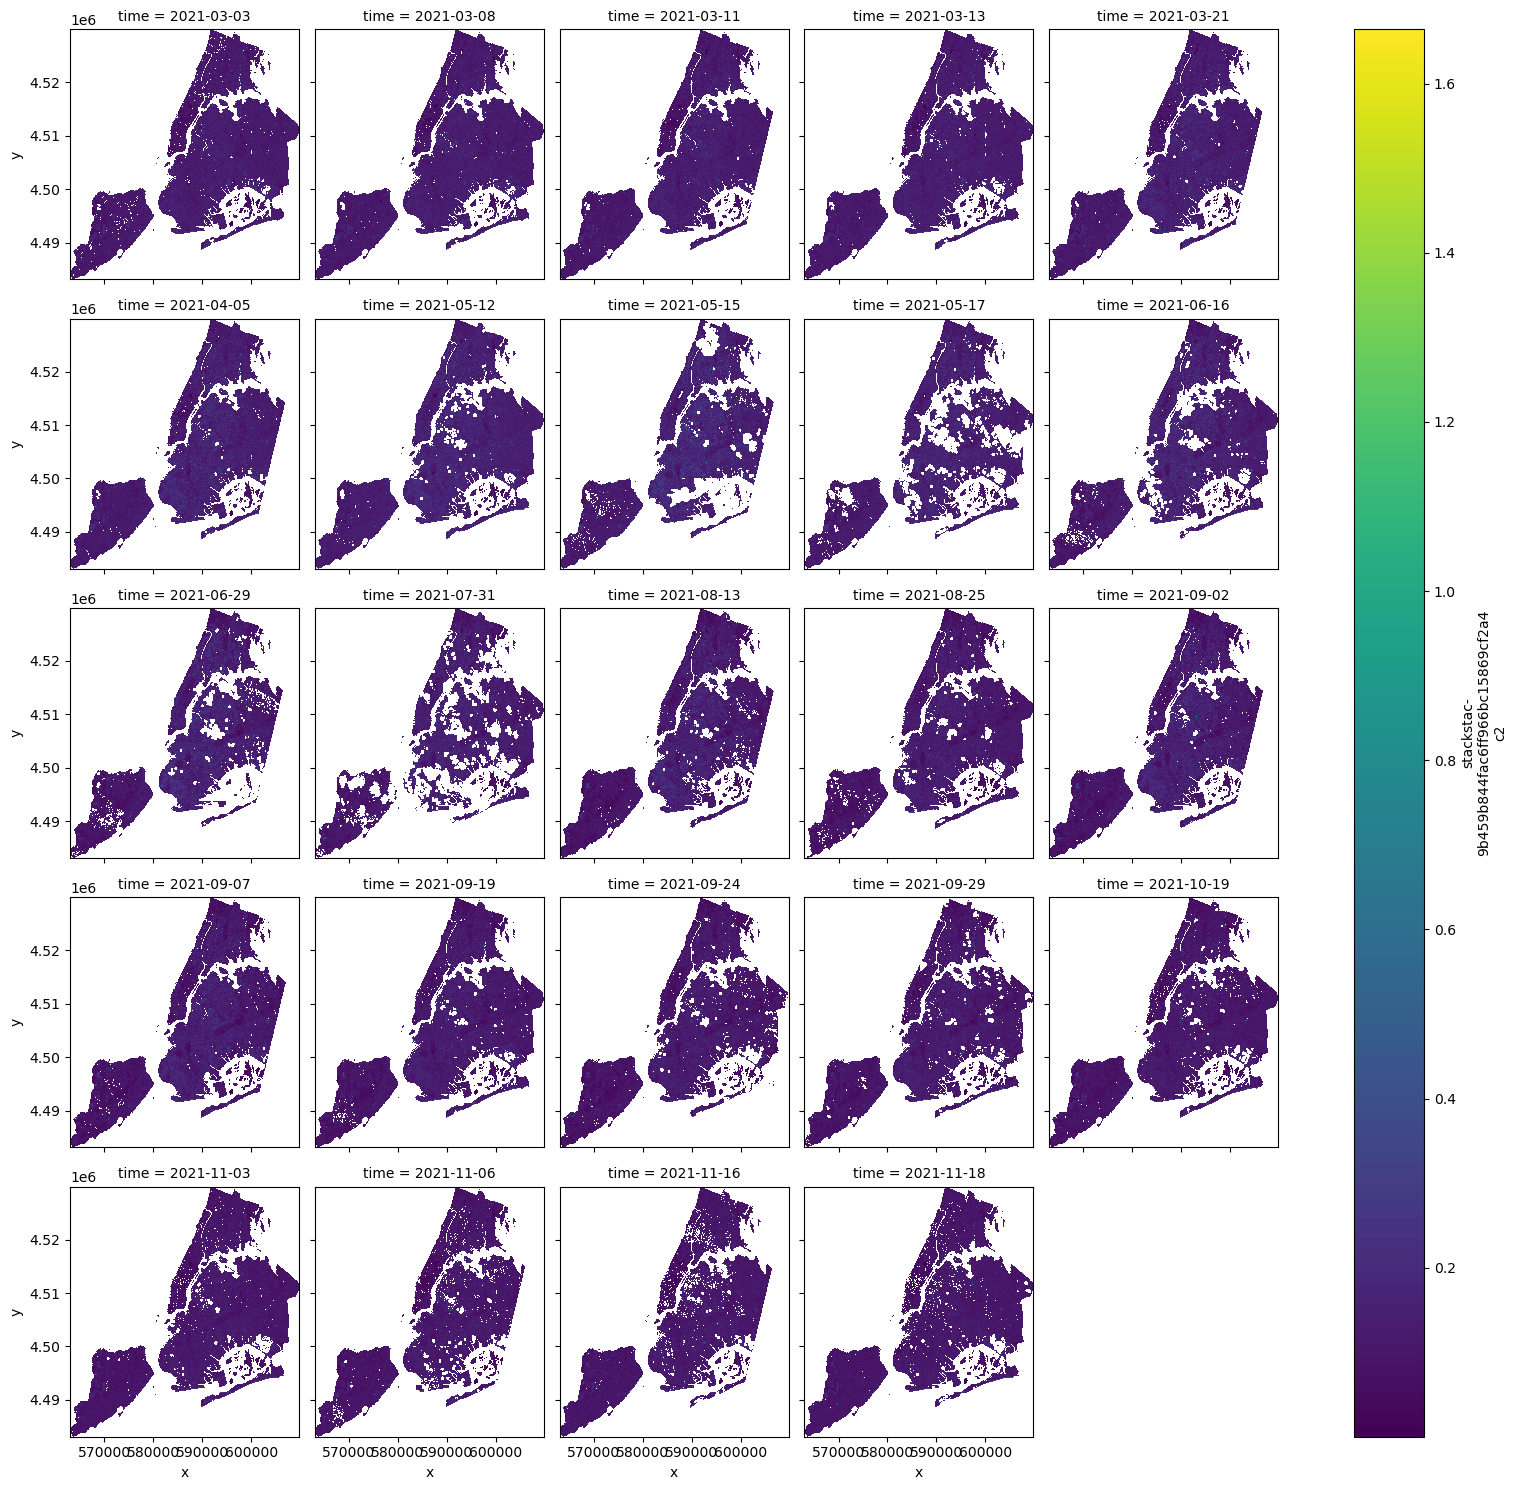

In [8]:
nyc_2021.filtered_sentinel.isel(band=3).plot(col='time',col_wrap=5)

In [10]:
nyc_2022 = HlsDownloader(nyc21,year='2022')
nyc_2022.get_stac_items()

found 186 landsat images
found 307 sentinel images
Suitable landsat images: Index(['2022-04-15', '2022-05-09', '2022-05-10', '2022-06-19', '2022-06-26',
       '2022-07-04', '2022-07-20', '2022-09-14', '2022-09-15', '2022-09-23',
       '2022-10-09', '2022-11-02', '2022-11-09', '2022-11-10'],
      dtype='object')
Suitable sentinel images: Index(['2022-04-02', '2022-04-12', '2022-04-15', '2022-04-20', '2022-04-22',
       '2022-04-30', '2022-05-10', '2022-06-04', '2022-06-06', '2022-06-19',
       '2022-07-04', '2022-07-11', '2022-07-19', '2022-08-03', '2022-08-18',
       '2022-08-25', '2022-09-02', '2022-09-09', '2022-09-14', '2022-09-19',
       '2022-10-07', '2022-10-09', '2022-10-12', '2022-10-22', '2022-10-27',
       '2022-10-29', '2022-11-08', '2022-11-18', '2022-11-21', '2022-11-23',
       '2022-11-26'],
      dtype='object')


In [11]:
# sentinel
nyc_2021.shift_date('sentinel','2021-11-03','2021-10-30')
nyc_2021.shift_date('sentinel','2021-06-29','2021-07-01')
nyc_2021.shift_date('sentinel','2021-08-13','2021-07-30')
nyc_2021.get_months_to_keep('sentinel',[7,10])
nyc_2022.get_months_to_keep('sentinel',[4])

# landsat
nyc_2022.shift_date('landsat','2022-11-02','2022-10-30')
nyc_2022.get_months_to_keep('landsat',[4,7,10])

In [12]:
nyc_combine = DataCombiner(nyc21,[nyc_2021,nyc_2022],2021)
nyc_combine.combine_data()
nyc_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21 / nyc21_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21 / nyc21_hls_indices.nc


In [ ]:
lst_dl = LstDownloader(nyc21)
lst_dl.lst_query(2021)
lst_dl.filter_lst(2021,[5,8,11])
lst_align = lst_dl.merge_lst([2021],common_year=2021)

#### NYC21v2: all  data from 2022 (no multi-year composite)

In [ ]:
nyc21v2 = Site(root=root,site_name='nyc21v2',epsg=26918)
nyc_2022 = HlsDownloader(site_object=nyc21v2,year='2022')
nyc_2022.get_stac_items()

found 186 landsat images
found 307 sentinel images


c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Suitable landsat images: Index(['2022-04-15', '2022-05-09', '2022-05-10', '2022-06-19', '2022-06-26',
       '2022-07-04', '2022-07-20', '2022-09-14', '2022-09-15', '2022-09-23',
       '2022-10-09', '2022-11-02', '2022-11-09', '2022-11-10'],
      dtype='object')
Suitable sentinel images: Index(['2022-04-02', '2022-04-12', '2022-04-15', '2022-04-20', '2022-04-22',
       '2022-04-30', '2022-05-10', '2022-06-04', '2022-06-06', '2022-06-19',
       '2022-07-04', '2022-07-11', '2022-07-19', '2022-08-03', '2022-08-18',
       '2022-08-25', '2022-09-02', '2022-09-09', '2022-09-14', '2022-09-19',
       '2022-10-07', '2022-10-09', '2022-10-12', '2022-10-22', '2022-10-27',
       '2022-10-29', '2022-11-08', '2022-11-18', '2022-11-21', '2022-11-23',
       '2022-11-26'],
      dtype='object')


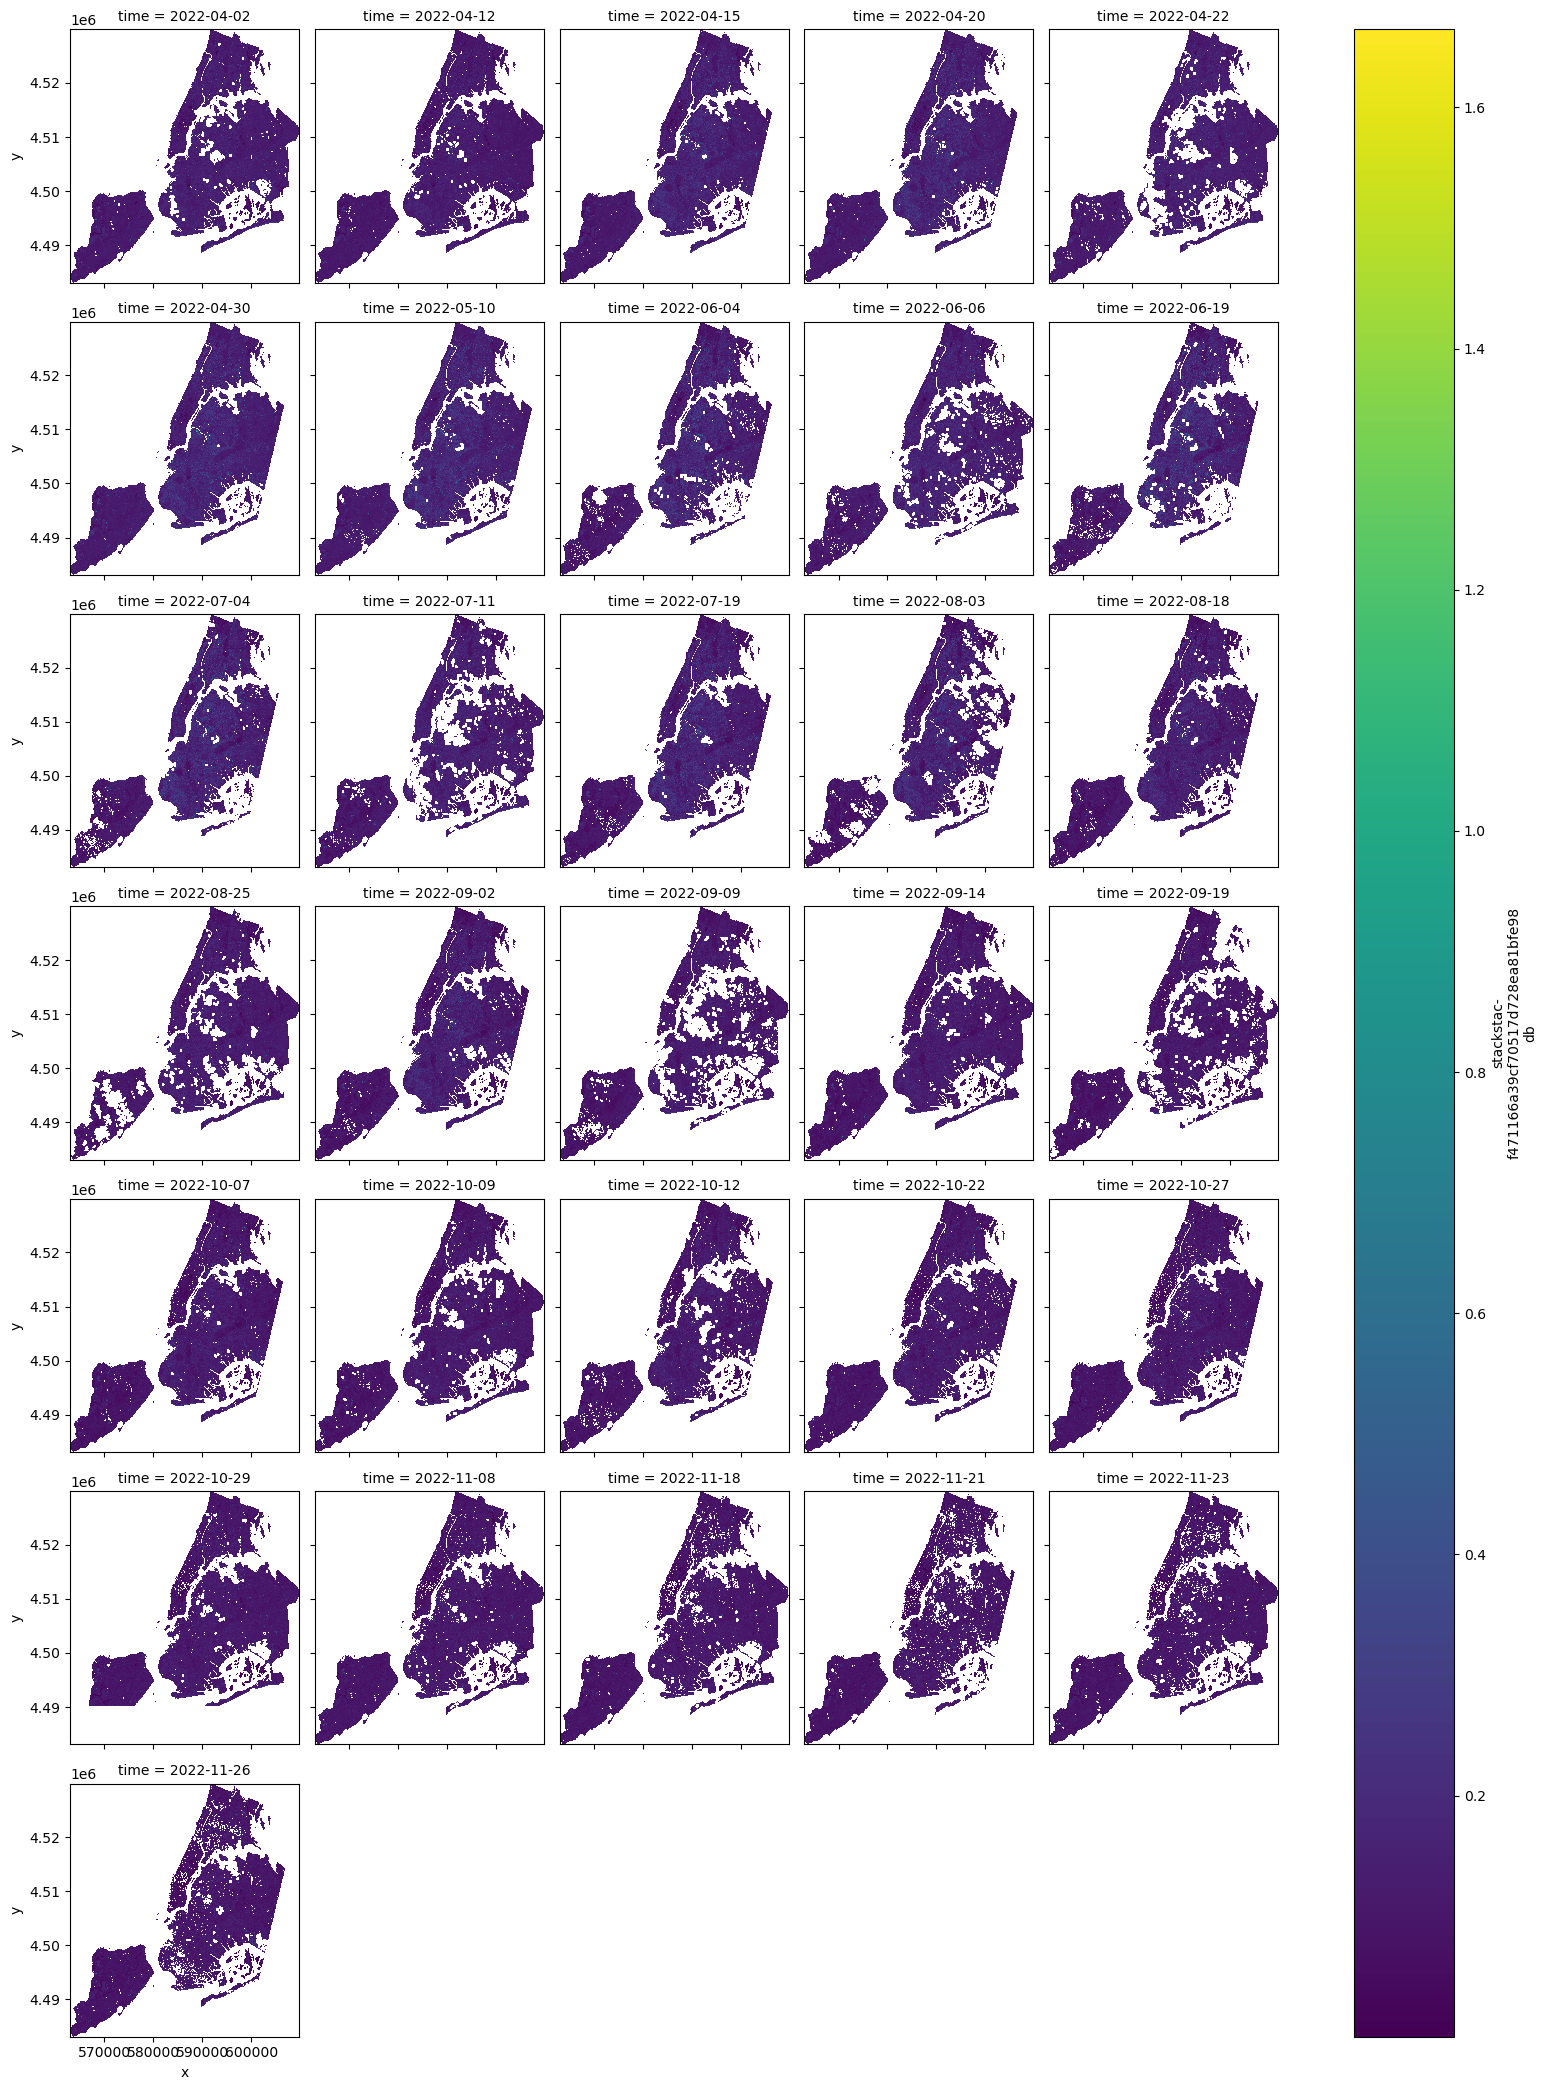

In [6]:
nyc_2022.filtered_sentinel.isel(band=3).plot(col='time',col_wrap=5)

In [7]:
nyc_2022.shift_date('landsat','2022-11-02','2022-10-30')
nyc_2022.get_months_to_keep('landsat',list_of_months=[4,7,10])
nyc_2022.get_months_to_keep('sentinel',list_of_months=[4,7,10])

In [8]:
nyc_combine = DataCombiner(nyc21v2,[nyc_2022],2021)
nyc_combine.combine_data()
nyc_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21v2 / nyc21v2_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21v2 / nyc21v2_hls_indices.nc


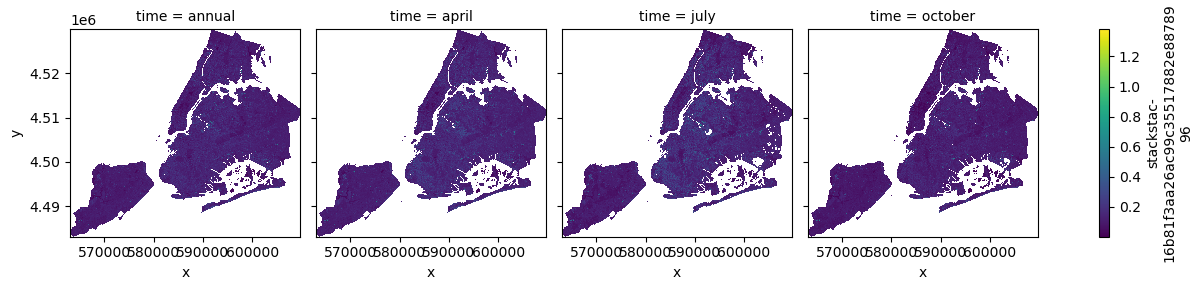

In [11]:
nyc_combine.output_bands.sel(band='rededge1').plot(col='time')

### NYC 2021: composite years 2019, 2020, 2022

In [11]:
nyc21 = Site(root=root,site_name='nyc21',epsg=26918)

In [ ]:
nyc_2019 = HlsDownloader(site_object=nyc21,year='2019')
nyc_2019.get_stac_items()

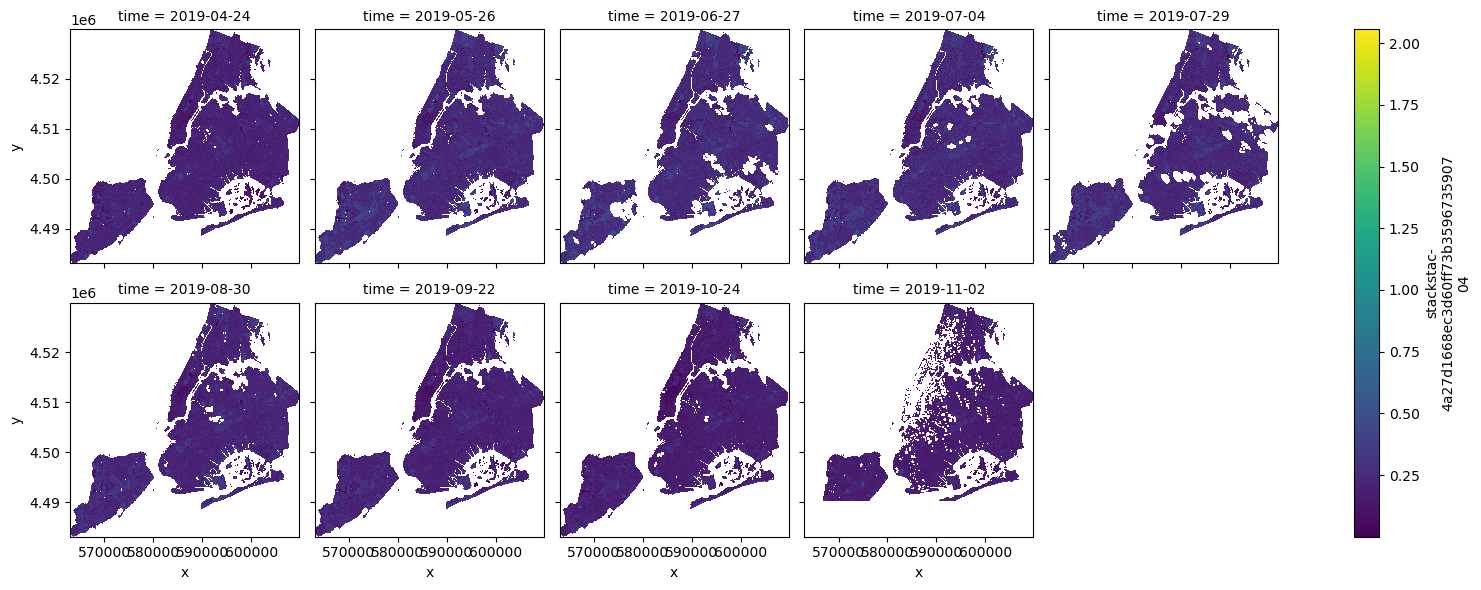

In [13]:
nyc_2019.filtered_landsat.isel(band=3).plot(col='time',col_wrap=5)

In [5]:
nyc_2020 = HlsDownloader(site_object=nyc21,year='2020')
nyc_2020.get_stac_items()

found 96 landsat images
found 295 sentinel images


c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Suitable landsat images: Index(['2020-05-12', '2020-06-13', '2020-07-06', '2020-10-03'], dtype='object')
Suitable sentinel images: Index(['2020-05-05', '2020-05-12', '2020-05-30', '2020-06-09', '2020-06-14',
       '2020-06-16', '2020-07-06', '2020-07-19', '2020-07-21', '2020-08-03',
       '2020-08-20', '2020-09-19', '2020-10-09', '2020-10-14', '2020-10-17',
       '2020-11-06', '2020-11-08'],
      dtype='object')


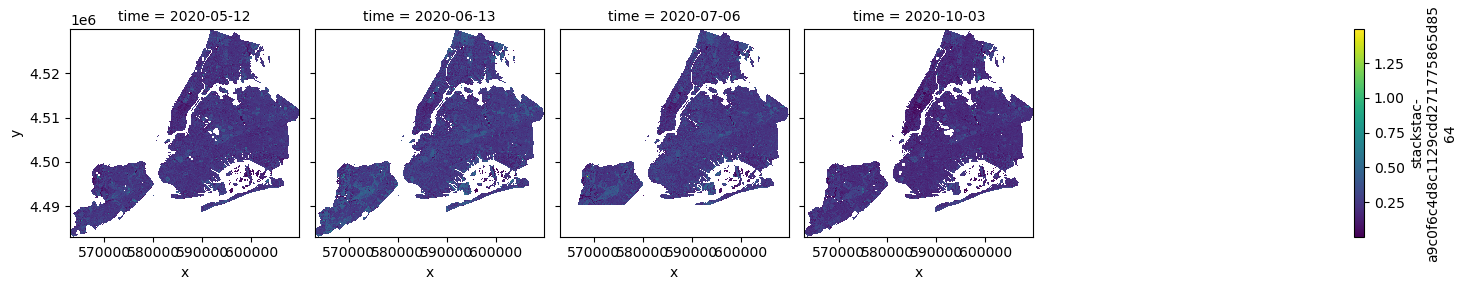

In [10]:
nyc_2020.filtered_landsat.isel(band=3).plot(col='time',col_wrap=5)

In [7]:
nyc_2022 = HlsDownloader(site_object=nyc21,year='2022')
nyc_2022.get_stac_items()

found 186 landsat images
found 307 sentinel images
Suitable landsat images: Index(['2022-04-15', '2022-05-09', '2022-05-10', '2022-06-19', '2022-06-26',
       '2022-07-04', '2022-07-20', '2022-09-14', '2022-09-15', '2022-09-23',
       '2022-10-09', '2022-11-02', '2022-11-09', '2022-11-10'],
      dtype='object')
Suitable sentinel images: Index(['2022-04-02', '2022-04-12', '2022-04-15', '2022-04-20', '2022-04-22',
       '2022-04-30', '2022-05-10', '2022-06-04', '2022-06-06', '2022-06-19',
       '2022-07-04', '2022-07-11', '2022-07-19', '2022-08-03', '2022-08-18',
       '2022-08-25', '2022-09-02', '2022-09-09', '2022-09-14', '2022-09-19',
       '2022-10-07', '2022-10-09', '2022-10-12', '2022-10-22', '2022-10-27',
       '2022-10-29', '2022-11-08', '2022-11-18', '2022-11-21', '2022-11-23',
       '2022-11-26'],
      dtype='object')


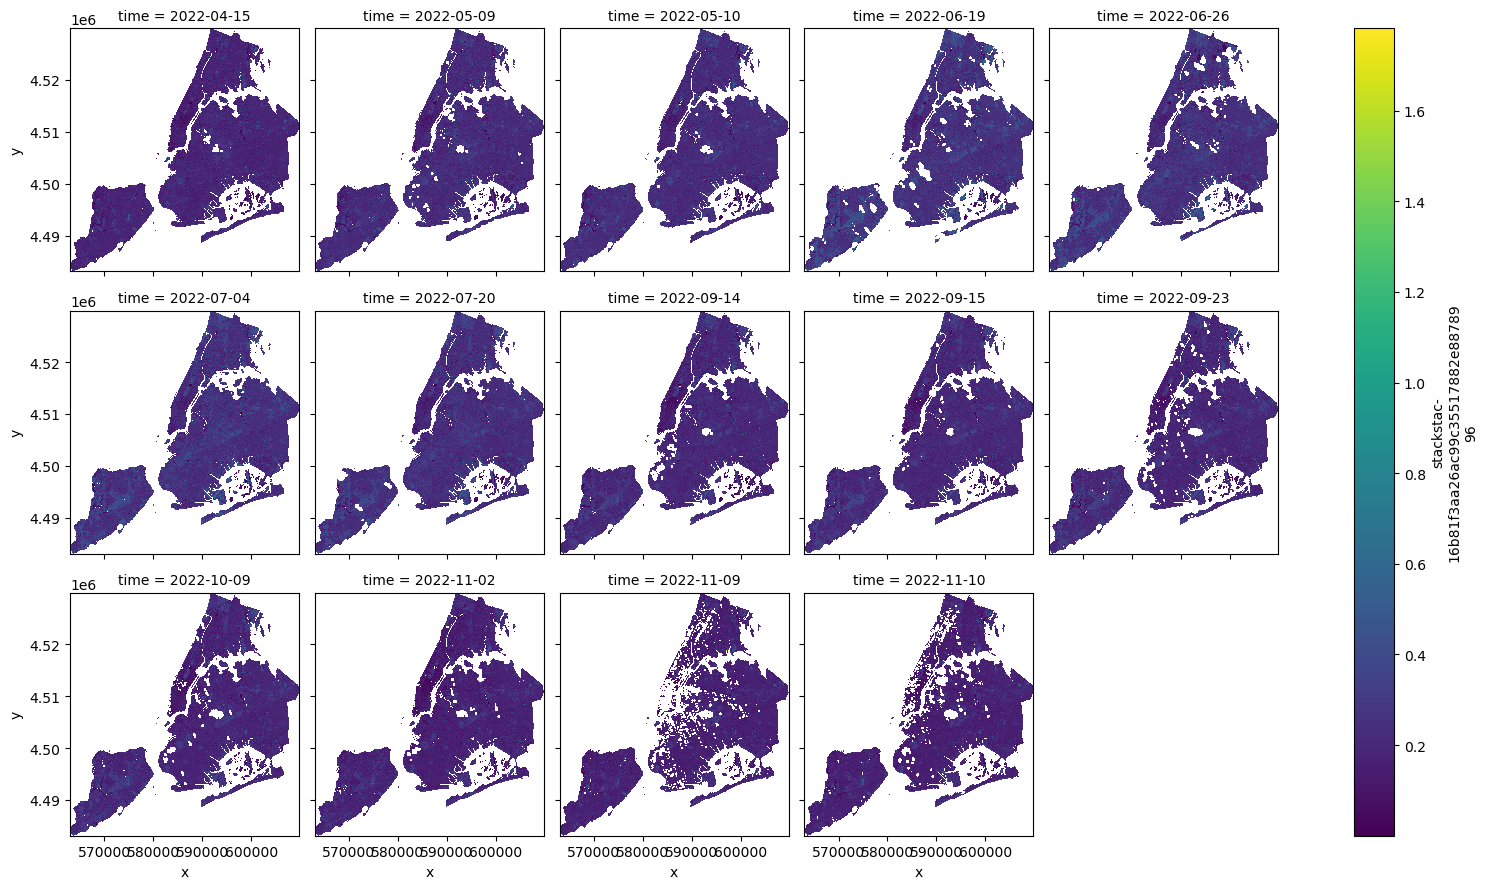

In [9]:
nyc_2022.filtered_landsat.isel(band=3).plot(col='time',col_wrap=5)

In [14]:
nyc_2020.shift_date('sentinel','2020-08-03','2020-07-31')
# sentinel
nyc_2020.get_months_to_keep('sentinel',[7,10])
nyc_2022.get_months_to_keep('sentinel',[4,7,10])

#landsat
nyc_2019.get_months_to_keep('landsat',[4,7,10])
nyc_2020.get_months_to_keep('landsat',[7,10])
nyc_2022.get_months_to_keep('landsat',[4,7,10])

In [15]:
nyc_combine = DataCombiner(nyc21,[nyc_2019,nyc_2020,nyc_2022],2021)
nyc_combine.combine_data()
nyc_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21 / nyc21_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21 / nyc21_hls_indices.nc


found 51 landsat images
['2021-04-04T00:00:00.000000000' '2021-05-06T00:00:00.000000000'
 '2021-05-15T00:00:00.000000000' '2021-06-07T00:00:00.000000000'
 '2021-06-16T00:00:00.000000000' '2021-06-23T00:00:00.000000000'
 '2021-08-26T00:00:00.000000000' '2021-09-04T00:00:00.000000000'
 '2021-09-11T00:00:00.000000000' '2021-09-20T00:00:00.000000000'
 '2021-09-27T00:00:00.000000000' '2021-11-04T00:00:00.000000000'
 '2021-11-09T00:00:00.000000000' '2021-11-23T00:00:00.000000000']


In [ ]:
#lst_dl.lst_2021.plot(col='time',col_wrap=5) # 5, 8, 11


aligning bands
saved lst to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21 / nyc21_lst.nc


In [37]:
lst_dl.lst_query(2022)

found 74 landsat images
['2022-04-08T00:00:00.000000000' '2022-04-15T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000' '2022-05-09T00:00:00.000000000'
 '2022-06-19T00:00:00.000000000' '2022-06-26T00:00:00.000000000'
 '2022-07-04T00:00:00.000000000' '2022-07-05T00:00:00.000000000'
 '2022-07-13T00:00:00.000000000' '2022-07-20T00:00:00.000000000'
 '2022-08-06T00:00:00.000000000' '2022-09-15T00:00:00.000000000'
 '2022-09-23T00:00:00.000000000' '2022-11-02T00:00:00.000000000'
 '2022-11-09T00:00:00.000000000' '2022-11-10T00:00:00.000000000'
 '2022-11-26T00:00:00.000000000']


In [38]:
lst_dl.lst_query(2020)

found 46 landsat images
['2020-05-12T00:00:00.000000000' '2020-06-04T00:00:00.000000000'
 '2020-06-13T00:00:00.000000000' '2020-07-06T00:00:00.000000000'
 '2020-07-22T00:00:00.000000000' '2020-09-08T00:00:00.000000000'
 '2020-10-03T00:00:00.000000000' '2020-10-10T00:00:00.000000000'
 '2020-11-20T00:00:00.000000000']


In [39]:
lst_dl.filter_lst(2022,[4,7])
lst_dl.filter_lst(2020,[10])

In [40]:
lst_align = lst_dl.merge_lst([2020,2022],common_year=2021)

aligning bands
saved lst to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / nyc21 / nyc21_lst.nc


In [1]:
def get_lst(site,year):
         
    catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                            modifier=planetary_computer.sign_inplace)

    query_results = catalog.search(
        bbox=site.bbox_4326,
        collections=['landsat-c2-l2'], # collection 2, level 2 science products
        datetime=f"{year}-04-01/{year}-11-30",
        query={"platform": {"in": ["landsat-8", "landsat-9"]}, # only search landsat 8 & 9
                }
    ).item_collection()

    print(f'found {len(query_results)} landsat images')

    x = stackstac.stack(
                query_results,
                epsg=site.epsg,
                resolution=30,
                bounds=site.bbox_utm,
                assets=['lwir11']).where(lambda x: x > 0, other=np.nan)
    # filter for images with low cloud cover
    lowcloud = x[x["eo:cloud_cover"] < 20]
    # clip to site boundaries
    lowcloud = lowcloud.rio.clip(geometries=site.boundary.geometry)
    # set time coord to just the day 
    lowcloud  = lowcloud.assign_coords(time=lowcloud['time'].dt.floor('D'))
    # # mosaic data from seperate tiles together
    mosaic = lowcloud.groupby('time').max(dim='time',skipna=True)
    # convert kelvin to celsius (stackstac automatically applies scale and offset)
    lst = mosaic.astype(float)
    lst = lst - 273.15  

    # get monthly and annual medians
    # monthly = lst.groupby('time.month').median('time').assign_coords({'month':['april','may','june','july','august', 'september','october','november']}).rename({'month':'time'})
    # annual = monthly.median('time').expand_dims({'time':['annual']}).assign_coords({'time':['annual']})
    # selected_months = monthly.sel(time=['april','july','october'])

    # # align lst with existing bands
    # match = xr.open_dataarray(site.root/'data'/site.site_name/f'{site.site_name}_hls_bands.nc').isel(band=0,time=0)
    # aligned_list = []
    # print('aligning bands')
    # for i in range(len(selected_months.time)):
    #     t = selected_months.isel(time=i)
    #     align = t.rio.reproject_match(match,resampling=Resampling.bilinear)
    #     aligned_list.append(align)

    # annual_sel = annual.isel(time=0)
    # align_annual = annual_sel.rio.reproject_match(match,resampling=Resampling.bilinear)
    # aligned_list.append(align_annual)
    # lst_align = xr.concat(aligned_list,dim='time')

    # # remove unneeded coords
    # lst_align = lst_align.reset_coords(['gsd','instruments','platform','raster:bands','view:off_nadir','description','landsat:collection_number','common_name','landsat:wrs_type','proj:code','landsat:correction','sci:doi','full_width_half_max','center_wavelength','title','spatial_ref'],drop=True)

    # lst_align.to_netcdf(site.root / 'data' / site.site_name/ f'{site.site_name}_lst.nc')
    # print(f'saved lst to {site.root} / data / {site.site_name} / {site.site_name}_lst.nc')

    # return lst_align
    setattr(self, f'lst_{year}',lst) 

In [ ]:
d = pd.to_datetime(sat.time.values) 
d_filtered = d[d.month.isin(list_of_months)].values

for obj in self.data_objs:
            months_to_keep = getattr(obj,f'{satellite}_months_to_keep')
            filtered_data = getattr(obj,f'filtered_{satellite}')
            if months_to_keep is not None:
                f = filtered_data.sel(time=months_to_keep)
                dt = pd.to_datetime(f.time).floor('d')
                dt = dt.map(lambda x: x.replace(year=self.year)).to_numpy() # set to common year
                f = f.assign_coords({'time':dt})
                data_list.append(f)
        # merge all years into one time series
        data = reduce(lambda x, y: x.combine_first(y), data_list)
        # rename bands
        data = data.assign_coords({'band':band_names})

In [12]:
nyc22_lst

<xarray.DataArray 'stackstac-aaf6b6b05746a54cda8bd779b33620b8' (time: 17,
                                                                band: 1,
                                                                y: 1561, x: 1557)> Size: 331MB
dask.array<sub, shape=(17, 1, 1561, 1557), dtype=float64, chunksize=(1, 1, 1022, 1023), chunktype=numpy.ndarray>
Coordinates: (12/20)
  * band                       (band) <U6 24B 'lwir11'
  * x                          (x) float64 12kB 5.631e+05 ... 6.098e+05
  * y                          (y) float64 12kB 4.53e+06 4.53e+06 ... 4.483e+06
    instruments                object 8B {'tirs', 'oli'}
    description                <U71 284B 'Collection 2 Level-2 Thermal Infrar...
    landsat:correction         <U4 16B 'L2SP'
    ...                         ...
    common_name                <U6 24B 'lwir11'
    center_wavelength          float64 8B 10.9
    full_width_half_max        float64 8B 0.59
    epsg                       int64 8B 26918
    spatial_ref                int64 8B 0
  * time                       (time) datetime64[ns] 136B 2022-04-08 ... 2022...

### Boston

In [4]:
# define site
boston = Site(root=root,site_name='boston', epsg=26919)

In [ ]:
# access satellite data for years of interest
b_2016 = HlsDownloader(site_object=boston,year=2016)

In [15]:
b_2016.get_stac_items()

found 26 landsat images
found 43 sentinel images
Suitable landsat images: Index(['2016-04-24', '2016-06-27', '2016-07-13', '2016-08-30', '2016-10-17'], dtype='object')
Suitable sentinel images: Index(['2016-06-17', '2016-06-24', '2016-08-03', '2016-08-23', '2016-09-12',
       '2016-09-25', '2016-10-15', '2016-11-14'],
      dtype='object')


In [ ]:
b_2016.plot_data(satellite='landsat',type='filtered')

In [16]:
b_2016.get_months_to_keep(satellite='landsat',list_of_months=[4,7])

In [17]:
b_2017 = HlsDownloader(site_object=boston,year=2017)
b_2017.get_stac_items()

found 22 landsat images
found 52 sentinel images
Suitable landsat images: Index(['2017-07-16', '2017-08-01', '2017-10-04', '2017-10-20'], dtype='object')
Suitable sentinel images: Index(['2017-06-12', '2017-07-02', '2017-07-09', '2017-08-06', '2017-08-31',
       '2017-10-17'],
      dtype='object')


In [18]:
b_2017.get_months_to_keep(satellite='landsat',list_of_months=[10])

In [19]:
b_2018 = HlsDownloader(site_object=boston,year=2018)
b_2018.get_stac_items()

found 26 landsat images
found 155 sentinel images
Suitable landsat images: Index(['2018-06-17', '2018-07-19', '2018-09-05', '2018-09-21'], dtype='object')
Suitable sentinel images: Index(['2018-04-05', '2018-04-23', '2018-05-08', '2018-05-30', '2018-06-12',
       '2018-06-17', '2018-06-19', '2018-06-29', '2018-07-02', '2018-07-07',
       '2018-07-09', '2018-07-12', '2018-07-19', '2018-08-26', '2018-08-28',
       '2018-09-05', '2018-09-30', '2018-10-17', '2018-10-22', '2018-11-04',
       '2018-11-11'],
      dtype='object')


In [20]:
b_2018.get_months_to_keep(satellite='sentinel',list_of_months=[4,7,10])

In [25]:
boston_combine = DataCombiner(boston,[b_2016,b_2017,b_2018],2016)

In [ ]:
# generate tree canopy raster from high-res landcover data
boston_combine.make_tree_canopy_tif(hi_res_filename='boston_hires_landcover_ccap_2016',tc_values=[9,10,11,13,16])

In [26]:
boston_combine.combine_data()

In [31]:
boston_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / boston / boston_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / boston / boston_hls_indices.nc


### Norfolk

In [3]:
norfolk = Site(root=root,site_name='norfolk',epsg=26919)

In [4]:
nf_2016 = HlsDownloader(norfolk,2016)

In [5]:
nf_2016.get_stac_items() # landsat 4,7

found 65 landsat images
found 105 sentinel images


c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Suitable landsat images: Index(['2016-04-24', '2016-06-27', '2016-07-13'], dtype='object')
Suitable sentinel images: Index(['2016-06-17', '2016-06-24', '2016-08-03', '2016-08-23', '2016-09-12',
       '2016-09-25', '2016-11-14'],
      dtype='object')


In [6]:
nf_2017 = HlsDownloader(norfolk,2017) # landsat 10, sentinel 7, 10
nf_2017.get_stac_items()

found 53 landsat images
found 127 sentinel images
Suitable landsat images: Index(['2017-08-01', '2017-10-04', '2017-10-20', '2017-11-21'], dtype='object')
Suitable sentinel images: Index(['2017-06-12', '2017-07-02', '2017-07-09', '2017-08-06', '2017-08-31',
       '2017-10-17'],
      dtype='object')


In [7]:
nf_2018 = HlsDownloader(norfolk,2018) # sentinel 4
nf_2018.get_stac_items()

found 59 landsat images
found 381 sentinel images
Suitable landsat images: Index(['2018-06-17', '2018-07-19', '2018-09-05', '2018-09-21'], dtype='object')
Suitable sentinel images: Index(['2018-04-05', '2018-04-23', '2018-05-08', '2018-05-30', '2018-06-12',
       '2018-06-17', '2018-06-19', '2018-07-02', '2018-07-07', '2018-07-09',
       '2018-07-12', '2018-07-19', '2018-08-26', '2018-08-28', '2018-09-05',
       '2018-09-30', '2018-10-17', '2018-10-22', '2018-11-04', '2018-11-11'],
      dtype='object')


In [8]:
nf_2016.get_months_to_keep(satellite='landsat',list_of_months=[4,7])
nf_2017.get_months_to_keep(satellite='landsat',list_of_months=[10])

nf_2017.get_months_to_keep(satellite='sentinel',list_of_months=[7,10])
nf_2018.get_months_to_keep(satellite='sentinel',list_of_months=[4])

In [9]:
norfolk_combine = DataCombiner(norfolk,[nf_2016,nf_2017,nf_2018],2016)

In [21]:
norfolk_combine.make_tree_canopy_tif(hi_res_filename='norfolk_hires_landcover_ccap_2016',tc_values=[9,10,11,13,16])

Tree canopy raster saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / norfolk / norfolk_tree_canopy.tif


In [10]:
norfolk_combine.combine_data()

In [11]:
norfolk_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / norfolk / norfolk_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / norfolk / norfolk_hls_indices.nc


### Fairfield

In [19]:
fairfield = Site(root=root, site_name='fairfield',epsg=26918)

In [ ]:
f_2016 = HlsDownloader(fairfield,2016) # sentinel 4, 10
f_2016.get_stac_items()

found 56 landsat images
found 76 sentinel images
Suitable landsat images: Index(['2016-04-15', '2016-06-18', '2016-09-22'], dtype='object')
Suitable sentinel images: Index(['2016-04-18', '2016-05-28', '2016-07-27', '2016-10-15', '2016-11-14'], dtype='object')


In [ ]:
f_2017 = HlsDownloader(fairfield,2017) # sentinel 7, landsat 4,10  
f_2017.get_stac_items()

found 56 landsat images
found 112 sentinel images
Suitable landsat images: Index(['2017-04-02', '2017-04-18', '2017-05-04', '2017-08-24', '2017-09-25',
       '2017-10-27', '2017-11-28'],
      dtype='object')
Suitable sentinel images: Index(['2017-04-23', '2017-06-12', '2017-07-02', '2017-08-16', '2017-08-31',
       '2017-09-25', '2017-10-20', '2017-11-29'],
      dtype='object')


In [ ]:
f_2018 = HlsDownloader(fairfield, 2018) # landsat 7
f_2018.get_stac_items()

found 52 landsat images
found 152 sentinel images
Suitable landsat images: Index(['2018-04-21', '2018-07-10'], dtype='object')
Suitable sentinel images: Index(['2018-04-08', '2018-04-23', '2018-05-08', '2018-06-12', '2018-06-17',
       '2018-07-02', '2018-07-07', '2018-07-12', '2018-08-16', '2018-08-26',
       '2018-11-04'],
      dtype='object')


In [30]:
f_2016.get_months_to_keep('sentinel',[4,10])

f_2017.get_months_to_keep('sentinel',[7])
f_2017.get_months_to_keep('landsat',[4,10])

f_2018.get_months_to_keep('landsat',[7])

f_combine = DataCombiner(fairfield,[f_2016,f_2017,f_2018],year=2016)

In [31]:
f_combine.make_tree_canopy_tif(hi_res_filename='fairfield_hires_landcover_ccap_2016',tc_values=[9,10,11,13,16])

Tree canopy raster saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / fairfield / fairfield_tree_canopy.tif


In [32]:
f_combine.combine_data()

In [33]:
f_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / fairfield / fairfield_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / fairfield / fairfield_hls_indices.nc


In [41]:
t = xr.open_dataarray(root / 'data' / 'baltimorecounty' / 'md_lc_2018_2022.tif')

In [ ]:
np.nanmax(t)

### Baltimore

In [4]:
baltimore = Site(root=root,site_name='baltimore',epsg=26918)

In [5]:
bt_2017 = HlsDownloader(baltimore,2017) # landsat 4, sentinel 10
bt_2017.get_stac_items()

found 15 landsat images
found 24 sentinel images


c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Suitable landsat images: Index(['2017-04-16', '2017-08-22'], dtype='object')
Suitable sentinel images: Index(['2017-05-16', '2017-09-28', '2017-10-03', '2017-10-18', '2017-11-02',
       '2017-11-17'],
      dtype='object')


In [6]:
bt_2019 = HlsDownloader(baltimore,2019) # landsat 7, 10, sentinel 4, 7
bt_2019.get_stac_items()

found 13 landsat images
found 38 sentinel images
Suitable landsat images: Index(['2019-04-06', '2019-05-24', '2019-07-27', '2019-08-12', '2019-10-15',
       '2019-11-16'],
      dtype='object')
Suitable sentinel images: Index(['2019-04-01', '2019-08-29', '2019-09-03', '2019-10-28'], dtype='object')


In [7]:
# sneaky: august 29th is now july 29th
a = bt_2019.filtered_sentinel.time.values
months = a.astype('datetime64[M]')
a[months == np.datetime64('2019-08')] = np.datetime64('2019-07-29')
bt_2019.filtered_sentinel = bt_2019.filtered_sentinel.assign_coords(time=a)

In [10]:
bt_2017.get_months_to_keep('landsat',[4])
bt_2019.get_months_to_keep('landsat',[7,10])

bt_2017.get_months_to_keep('sentinel',[10])
bt_2019.get_months_to_keep('sentinel',[4,7])


In [11]:
bt_combine = DataCombiner(baltimore,[bt_2017,bt_2019],year=2017)

In [14]:
bt_combine.combine_data()

In [15]:
bt_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / baltimore / baltimore_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / baltimore / baltimore_hls_indices.nc


### Baltimore County

In [3]:
balt_county = Site(root=root,site_name='baltimorecounty',epsg=26918)

In [ ]:
bc_2017 = HlsDownloader(balt_county,2017) # landsat 4, sentinel 10
bc_2017.get_stac_items()

found 19 landsat images
found 50 sentinel images


c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
c:\Users\roseh\miniconda3\envs\utc-env\Lib\site-packages\dask\array\reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Suitable landsat images: Index(['2017-04-16', '2017-08-22'], dtype='object')
Suitable sentinel images: Index(['2017-05-16', '2017-07-30', '2017-08-04', '2017-09-28', '2017-10-03',
       '2017-10-18', '2017-11-02', '2017-11-17'],
      dtype='object')


In [ ]:
bc_2018 = HlsDownloader(balt_county,2018) # sentinel 7, landsat 7
bc_2018.get_stac_items()

found 16 landsat images
found 69 sentinel images
Suitable landsat images: Index(['2018-07-08'], dtype='object')
Suitable sentinel images: Index(['2018-04-26', '2018-05-01', '2018-06-15', '2018-07-10', '2018-08-29',
       '2018-10-23'],
      dtype='object')


In [ ]:
bc_2019 = HlsDownloader(balt_county,2019) # landsat 10, sentinel 4
bc_2019.get_stac_items()

found 14 landsat images
found 72 sentinel images
Suitable landsat images: Index(['2019-05-24', '2019-07-27', '2019-08-12', '2019-10-15', '2019-11-16'], dtype='object')
Suitable sentinel images: Index(['2019-04-01', '2019-04-06', '2019-06-30', '2019-07-25', '2019-07-30',
       '2019-08-19', '2019-08-29', '2019-09-03', '2019-09-08', '2019-10-28',
       '2019-11-02'],
      dtype='object')


In [13]:
bc_2017.get_months_to_keep('landsat',[4])
bc_2017.get_months_to_keep('sentinel',[10])

bc_2018.get_months_to_keep('landsat',[7])
bc_2018.get_months_to_keep('sentinel',[7])

bc_2019.get_months_to_keep('landsat',[10])
bc_2019.get_months_to_keep('sentinel',[4])



In [14]:
bc_combine = DataCombiner(balt_county,[bc_2017,bc_2018,bc_2019],2017)

In [16]:
bc_combine.make_tree_canopy_tif('baltcounty_hires_landcover',[3,10,11,12])

Tree canopy raster saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / baltimorecounty / baltimorecounty_tree_canopy.tif


In [17]:
bc_combine.combine_data()

In [18]:
bc_combine.save_outputs()

Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / baltimorecounty / baltimorecounty_hls_bands.nc
Bands saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\urban_canopy / data / baltimorecounty / baltimorecounty_hls_indices.nc


### Crop hi-res maryland landcover

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

t = xr.open_dataarray(root / 'data' / 'baltimorecounty' / 'md_lc_2018_2022.tif')

b = gpd.read_file(root / 'data' / 'baltimorecounty' / 'baltimorecounty_boundary.gpkg')

b = b.to_crs(t.rio.crs)

geom = [mapping(geom) for geom in b.geometry]

# Open raster and clip
with rasterio.open(root / 'data' / 'baltimorecounty' / 'md_lc_2018_2022.tif') as src:
    out_image, out_transform = mask(src, geom, crop=True)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save to disk 
with rasterio.open(root / 'data' / 'baltimorecounty' / "baltcounty_hires_landcover.tif", "w", **out_meta) as dest:
    dest.write(out_image)

### Crop NLCD

In [1]:
from pathlib import Path
import os

import geopandas as gpd
import xarray as xr
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

def crop_and_save_tif(src_raster_filepath,site,output_filename):
        
        os.makedirs(root / 'data' / site, exist_ok=True)
        
        b = gpd.read_file(root / 'data' / 'nyc_boundary.gpkg')

        t = xr.open_dataarray(src_raster_filepath)

        b = b.to_crs(t.rio.crs) # transform boundary bc it's faster than reprojecting a giant raster

        geom = [mapping(geom) for geom in b.geometry]

        # Open raster and clip to site boundary
        with rasterio.open(src_raster_filepath) as src:
            out_image, out_transform = mask(src, geom, crop=True)
            out_meta = src.meta.copy()

        # Update metadata
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Save to disk 
        with rasterio.open(root / 'data' / site / f"{output_filename}.tif", "w", **out_meta) as dest:
            dest.write(out_image)
        print(f'{site} file saved to: {root}/data/{site}/{output_filename}.tif')






In [2]:
root = Path.cwd()

site = 'nlcd'
src_raster_filepath = Path(r"C:\Users\roseh\Documents\large_files_storage\nlcd\nlcd_2023.tif")
output_filename = 'nlcd_tc_2023'


crop_and_save_tif(src_raster_filepath,site,output_filename)

nlcd file saved to: c:\Users\roseh\My Drive\urban_canopy\urban_canopy/data/nlcd/nlcd_tc_2023.tif


In [ ]:
root = Path.cwd()
src_raster_filepath = root / 'data' / 'nlcd_source_files' / 'nlcd_landcover_2017.tif'
output_filename = 'landcover_2017'
t = xr.open_dataarray(src_raster_filepath)

site_list = ['baltimorecounty','baltimore','norfolk','boston','fairfield']

for site in site_list:
     crop_and_save_tif(src_raster_filepath,site,output_filename)

### Vectorize Raster Grid

In [ ]:
from pathlib import Path
root = Path.cwd()
import rasterio
import fiona
from rasterio.features import shapes
import numpy as np

image = xr.open_dataarray(root / 'data' / 'nyc' / 'nyc_hls_bands.nc')
image = image.isel(band=0,time=0)

# create raster with unique value per pixel
r1_unique = np.arange(image.size).reshape(image.shape) 
r1_unique = r1_unique.astype('uint16') 
r1 = xr.DataArray(r1_unique, coords={'y': image.y.values, 'x': image.x.values},dims=['y','x'])
r1 = r1.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
#polygons = shapes(r1_unique, transform=r1.rio.transform()) # returns (geojson, value) for each raster grid cell

# Prepare output schema
schema = {
    'geometry': 'Polygon',
    'properties': {'value': 'int'}
}

# Open output file for writing
with fiona.open(
    'nyc_grid.gpkg',
    mode='w',
    driver='GPKG',  # or 'GeoJSON'
    crs=image.rio.crs,
    schema=schema
) as output:
    for geom, val in shapes(r1_unique, transform=r1.rio.transform()):
        output.write({
            'geometry': geom,
            'properties': {'value': int(val)}
        })

### Create NYC Wetland GPKG

In [ ]:
## create wetland gpkg
vector_file = root / 'data' / 'nyc' / 'wetland' /'wetland.shp'

vec_gdf = gpd.read_file(vector_file)
vec_gdf = vec_gdf.to_crs(26918)

classnames = vec_gdf['classname'].unique()
class_dict = { name:i for i, name in enumerate(classnames)}
vec_gdf['class_num'] = vec_gdf['classname'].map(class_dict).astype(int)

vec_gdf.to_file(root / 'data' / 'nyc' / 'wetland.gpkg')

In [43]:
class_dict

{'Emergent': 0,
 'Forested': 1,
 'Water-Estuarine': 2,
 'Water': 3,
 'Scrub/Shrub': 4,
 'Estuarine': 5}

### Rasterize Vector Grid

In [1]:
from pathlib import Path
root = Path.cwd()
import xarray as xr
import fiona
import rasterio
from rasterio.features import rasterize
import numpy as np

# reference raster
image = xr.open_dataarray(root / 'data' / 'nyc' / 'nyc_hls_bands.nc')
image = image.isel(band=0,time=0)

# Define raster output parameters
out_shape = (image.shape[0], image.shape[1]) 
bounds = image.rio.bounds()  
transform = image.rio.transform()
crs = image.rio.crs 

vector_file = root / 'data' / 'nyc' / 'wetland.gpkg'

# # Stream features into rasterizer
column_name = 'class_num'  # set value to burn
output_filename = root / 'data' / 'nyc' / 'wetland2.tif'

raster = np.full(out_shape, 6.0, dtype=np.float32) # raster of np.nan

with fiona.open(vector_file) as src:
    shapes = ((feature["geometry"], feature['properties'][column_name]) for feature in src)  # generator
    raster = rasterize(shapes=shapes, out=raster, transform=transform)

    
# # Save to file
with rasterio.open(
    output_filename, "w",
    driver="GTiff",
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs=crs,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)

In [3]:
import geopandas as gpd
# crop wetlands to nyc boundaries
w = xr.open_dataarray(root / 'data' / 'nyc' / 'wetland2.tif')

nyc_b = gpd.read_file(root / 'data' / 'nyc' / 'nyc_boundary.gpkg')

w = w.rio.clip(geometries=nyc_b.geometry)
w.rio.to_raster(root / 'data' / 'nyc' / 'wetland2_crop.tif')

### Resample NAC Landcover

In [ ]:
import geopandas as gpd
import xarray as xr
import rioxarray
from pathlib import Path 
from rasterio.enums import Resampling
from dask.diagnostics import ProgressBar

root = Path.cwd()

landcover = rioxarray.open_rasterio(root / 'data' / 'nyc' / 'nac_landcover' / f'ECM_Combine_Full_Rasterv2.tif',
                                    chunks=True)

image = xr.open_dataarray(root / 'data' / 'nyc' / 'nyc_hls_bands.nc')
image = image.isel(band=0,time=0)

with ProgressBar():
    nac_30m = landcover.rio.reproject_match(image,resampling=Resampling.mode)
    nac_30m.rio.to_raster(root / 'data' / 'nyc' / 'nac_30m.tif')


In [ ]:
# crop to nyc boundaries
nac_30m = rioxarray.open_rasterio(root / 'data' / 'nyc' / 'nac_30m.tif')

nyc_b = gpd.read_file(root / 'data' / 'nyc' / 'nyc_boundary.gpkg')

nac_crop = nac_30m.rio.clip(geometries=nyc_b.geometry)

nac_crop.rio.to_raster(root / 'data' / 'nyc' / 'nac_30m_crop.tif')

In [10]:
#nac_crop = nac_crop.where(nac_crop >= 0)

#nac_crop.plot()

nac_crop.rio.to_raster(root / 'data' / 'nyc' / 'nyc_nac_30m.tif')

In [ ]:
## old class

class HlsDownloader():
    def __init__(self,site_object,year):
        self.landsat_bands = ["B02","B03","B04","B05","B06","B07","B10","B11","Fmask"]
        self.sentinel_bands = ["B02","B03","B04","B05","B06","B07","B8A","B11","B12","Fmask"]
        self.site = site_object
        self.year = year

        self.all_landsat = None
        self.all_sentinel = None

        self.filtered_landsat = None
        self.filtered_sentinel = None

        # self.lst = None
        # self.pheno = None

        self.pixel_threshold = None

        self.landsat_timestamps_df = None
        self.sentinel_timestamps_df = None

        self.landsat_months_to_keep = None
        self.sentinel_months_to_keep = None

            
    def get_stac_items(self):

        catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")


        query_results = catalog.search(
            bbox=self.site.bbox_4326,
            collections=["HLSL30.v2.0","HLSS30.v2.0"],
            datetime=f"{self.year}-04-01/{self.year}-11-30"
        ).item_collection()


        landsat_items = [item for item in query_results if item.collection_id == "HLSL30_2.0"]
        print(f'found {len(landsat_items)} landsat images')
        sentinel_items = [item for item in query_results if item.collection_id == "HLSS30_2.0"]
        print(f'found {len(sentinel_items)} sentinel images')

        # convert to xarray and crop to city boundaries
        self.all_landsat = self.process_items(landsat_items,self.landsat_bands)
        self.all_sentinel = self.process_items(sentinel_items,self.sentinel_bands)

        self.cloud_mask = self.make_cloud_mask(self.all_landsat)
        
        # remove timesteps with < %70 pixels, also mask and scale data
        self.filtered_landsat = self.filter_mask_scale('landsat')
        self.filtered_sentinel = self.filter_mask_scale('sentinel')

        self.landsat_timestamps_df = self.make_timestamps_df('landsat')
        self.sentinel_timestamps_df = self.make_timestamps_df('sentinel')

    def process_items(self,items,bands):

        # create xarray
        x = stackstac.stack(
            items,
            epsg=self.site.epsg,
            resolution=30,
            bounds=self.site.bbox_utm,
            assets=bands).where(lambda x: x > 0, other=np.nan)
        # filter for images with low cloud cover
        lowcloud = x[x["eo:cloud_cover"] < 30]

        lowcloud = lowcloud.rio.clip(geometries=self.site.boundary.geometry)

        # set time coord to just the day 
        lowcloud  = lowcloud.assign_coords(time=lowcloud['time'].dt.floor('D'))

        # mosaic data from seperate tiles together
        mosaic = lowcloud.groupby('time').max(dim='time',skipna=True)   

        ### pixel threshold to get rid of partial data
        if self.pixel_threshold == None:
            self.pixel_threshold = self.get_valid_pixel_threshold(data=mosaic)

        return mosaic

    # def make_cloud_mask(self,satellite):

    #     fmask_values= np.unique(satellite.sel(band='Fmask'))
    #     # convert fmask values to binary
    #     all_bits = list()
    #     for v in fmask_values[:-1]:
    #             all_bits.append(format(int(v), 'b').zfill(8))
       
    #     qa = list()
    #     for b in all_bits:
    #             if int(b[3]) + int(b[4]) + int(b[6]) == 0:    # if bits in these positions are all zero then quality is good
    #                     qa.append('good')
    #             else:
    #                     qa.append('poor')

    #     keep_values = list()
    #     for (quality, value) in (zip(qa,fmask_values)):
    #             if quality == 'good':
    #                     keep_values.append(value)

    #     return keep_values
    
    def create_quality_mask(self, quality_data, bit_nums: list = [1, 2, 3, 4]):
        """
        Uses the Fmask layer and bit numbers to create a binary mask of good pixels.
        https://github.com/nasa/HLS-Data-Resources/blob/main/python/tutorials/EVI_timeseries_with_odc_stac.ipynb
        """
        mask_array = np.zeros((quality_data.shape[0], quality_data.shape[1]))
        # Remove/Mask Fill Values and Convert to Integer
        quality_data = np.nan_to_num(quality_data.copy(), nan=255).astype(np.int8)
        for bit in bit_nums:
            # Create a Single Binary Mask Layer
            mask_temp = np.array(quality_data) & 1 << bit > 0
            mask_array = np.logical_or(mask_array, mask_temp)
        return mask_array

    def get_valid_pixel_threshold(self,data):
        s = data.isel(band=0,time=0)

        rasterized = rasterize(self.site.boundary.geometry,
                                        out_shape = s.shape,
                                        fill = 0,
                                        out = None,
                                        transform = s.rio.transform(),
                                        all_touched = False,
                                        default_value = 1,
                                        dtype = 'int8')
        return rasterized.sum()


    def filter_mask_scale(self,satellite):
        data = getattr(self,f'all_{satellite}')

        ################ apply qa mask to data #######################
        fmask = data.sel(band='Fmask')
        # number of bands
        # assert data.dims[1] == 'band', f"array dimensions should be (time,band,y,x),not {data.dims}"
        # dim_size = data.shape[1]
        
        valid = fmask.isin(self.cloud_mask) 
#         # apply cloud mask
        masked = data.where(valid)
 
        masked = masked.drop_sel(band='Fmask')  # drop fmask band

        ############## filter out timesteps with incomplete data ############ 
        num_valid_pixels = masked.isel(band=1).count(dim=('y','x'))
        
        # make boolean arrays showing if timesteps at least 75% of pixels
        valid_slices = num_valid_pixels.values >= self.pixel_threshold*.75


        filtered = masked.isel(time=valid_slices)
        


        ################ apply scaling factors ####################
        if satellite == 'landsat':
                scaled1 = filtered.isel(band=slice(0,6)) * .0001   
                scaled2 = filtered.isel(band=slice(6,None)) * .01       

                scaled = xr.concat([scaled1,scaled2], dim='band')
        else:
                scaled = filtered * .0001
                

        return scaled
    
    def make_timestamps_df(self, satellite):
        all_data = getattr(self, f'all_{satellite}')
        filtered_data = getattr(self, f'filtered_{satellite}')

        all_dates = pd.to_datetime(all_data.time.values).strftime('%Y-%m-%d')
        filtered_dates = pd.to_datetime(filtered_data.time.values).strftime('%Y-%m-%d')
        print(f'Suitable {satellite} images: {filtered_dates}')

        # add nans to make sure length matches
        filtered_dates = list(filtered_dates) + [np.nan] * (len(all_dates) - len(filtered_dates))

        return pd.DataFrame({f'all_{satellite}': all_dates, f'filtered_{satellite}': filtered_dates})
    
    def shift_date(self,satellite,time_a,time_b):
        s = getattr(self,f'filtered_{satellite}')
        times = s.time.values
        days = times.astype('datetime64[D]')
        times[days == np.datetime64(time_a)] = np.datetime64(time_b)
        s = s.assign_coords(time=times)
        setattr(self, f'filtered_{satellite}', s)
    
    def get_months_to_keep(self,satellite,list_of_months):
        sat = getattr(self,f'filtered_{satellite}')

        d = pd.to_datetime(sat.time.values) 
        d_filtered = d[d.month.isin(list_of_months)].values

        setattr(self, f'{satellite}_months_to_keep', d_filtered)

        path = self.site.root / 'data' / self.site.site_name / 'satellite_image_dates.txt'
        path.touch()  
        with path.open('a+') as file:
            file.write(f'\nSite: {self.site.site_name} \nSatellite: {satellite}\n Dates: {d_filtered}\n\n' )

         



   
class DataCombiner():
    def __init__(self,site_obj,data_objs,year):
        self.site_obj = site_obj
        self.data_objs = data_objs
        self.year = year

        self.output_bands = None
        self.output_indices = None
    
    def make_tree_canopy_tif(self,hi_res_filename,tc_values):
    # c-cap tree canopy values = [9,10,11,13,16]
        if os.path.exists(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_tree_canopy.tif'):
            print("Tree canopy tif already exists")
        else:

            landcover = rioxarray.open_rasterio(self.site_obj.root / 'data' / self.site_obj.site_name / f'{hi_res_filename}.tif')
            landcover = landcover.rio.reproject(f"EPSG:{self.site_obj.epsg}")
            landcover = landcover.rio.clip(geometries=self.site_obj.boundary.geometry)

            # Reclassify tc values to 1, all other values to 0
            landcover_recat = xr.where(landcover.isin(tc_values), 1, 0).astype('float32')

            # get reference raster
            match = self.data_objs[0].filtered_landsat.isel(time=0,band=0)

            # resample 1m binary raster to 30m using average; gives percent per 30m pixel
            tc_30m = landcover_recat.rio.reproject_match(match,resampling=Resampling.average)

            tc_30m.rio.to_raster(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_tree_canopy.tif')
            print(f'Tree canopy raster saved to {self.site_obj.root} / data / {self.site_obj.site_name} / {self.site_obj.site_name}_tree_canopy.tif')


    def combine_data_by_satellite(self,satellite):
        # takes data from same satellite and different years and creates unified time series
        if satellite == 'sentinel':
            band_names = ['blue','green','red','rededge1','rededge2','rededge3','nir','sw1','sw2']
        else:
            band_names = ['blue','green', 'red','nir','sw1','sw2','tir1','tir2']

        data_list = []
        for obj in self.data_objs:
            months_to_keep = getattr(obj,f'{satellite}_months_to_keep')
            filtered_data = getattr(obj,f'filtered_{satellite}')
            if months_to_keep is not None:
                f = filtered_data.sel(time=months_to_keep)
                dt = pd.to_datetime(f.time).floor('d')
                dt = dt.map(lambda x: x.replace(year=self.year)).to_numpy() # set to common year
                f = f.assign_coords({'time':dt})
                data_list.append(f)
        # merge all years into one time series
        data = reduce(lambda x, y: x.combine_first(y), data_list)
        # rename bands
        data = data.assign_coords({'band':band_names})
            
        return data
    
    def aggregate_annual_monthly(self,data):
        # aggregates time series data to annual and  monthly time steps
        annual = data.median('time').expand_dims('time').assign_coords({'time':['annual']})
        monthly = data.groupby('time.month').median('time').assign_coords({'month':['april','july','october','november']}).rename({'month':'time'})
        return annual, monthly
    
    def rasters_aligned(self,r1, r2):
        return (
            r1.rio.crs == r2.rio.crs and
            r1.rio.resolution() == r2.rio.resolution() and
            np.array_equal(r1.x, r2.x) and
            np.array_equal(r1.y, r2.y)
        )
    
    def combine_data(self,add_tc=True):
        # create unified time series for each satellite
        landsat_data = self.combine_data_by_satellite(satellite='landsat')
        sentinel_data = self.combine_data_by_satellite(satellite='sentinel')

        # names of shared bands, unique sentinel bands & unique landsat bands
        shared_band_list = ['blue','green','red','nir','sw1','sw2']
        sentinel_band_list = ['rededge1', 'rededge2', 'rededge3']
        landsat_band_list = ['tir1','tir2']

        # lists to hold aggregated data
        annual_list = []
        monthly_list = []

        shared_bands = landsat_data.sel(band=shared_band_list).combine_first(sentinel_data.sel(band=shared_band_list))
        l_only_bands = landsat_data.sel(band=landsat_band_list)
        s_only_bands = sentinel_data.sel(band=sentinel_band_list)

        for a in [shared_bands,l_only_bands,s_only_bands]:
            b = a.median('time').expand_dims('time').assign_coords({'time':['annual']})
            annual_list.append(b)

        for a in [shared_bands,l_only_bands,s_only_bands]:
            b = a.groupby('time.month').median('time').assign_coords({'month':['april','july','october','november']}).rename({'month':'time'})
            monthly_list.append(b)
            
        # stack all aggregated bands together
        annual = xr.concat(annual_list,dim='band')
        monthly = xr.concat(monthly_list,dim='band')

        # add tree canopy
        if add_tc == True:
            tc = self.site_obj.tree_canopy.assign_coords({'band':['tc']})
            # align tree canopy raster with satellite data; bilinear resampling strategy
            if self.rasters_aligned(tc,annual.isel(band=1,time=0)) == False:
                tc = tc.rio.reproject_match(annual.isel(band=1,time=0), resampling=Resampling.bilinear)
            
            tc = tc.expand_dims({'time':['annual']})

            c1 = xr.concat([annual,tc],dim='band')

            self.output_bands = xr.concat([c1,monthly],dim='time')
        else:
            self.output_bands = xr.concat([annual,monthly],dim='time')

        ###### calculate indices #######
        # daily indices calculated first, then aggregated to month and year.

        shared_indices = []
        # tdvi
        shared_indices.append(1.5*((shared_bands.sel(band='nir')-shared_bands.sel(band='red'))/(shared_bands.sel(band='nir')**2+shared_bands.sel(band='red')+0.5)**0.5))
        # ndwi
        shared_indices.append((shared_bands.sel(band='green')-shared_bands.sel(band='nir'))/(shared_bands.sel(band='green')+shared_bands.sel(band='nir')))
        # msavi
        shared_indices.append(((2*shared_bands.sel(band='nir')+1)-((2*shared_bands.sel(band='nir')+1)**2-8*(shared_bands.sel(band='nir')-shared_bands.sel(band='red')))**0.5)/2)
        #brightness
        shared_indices.append((shared_bands.sel(band='blue')*0.3029)+(shared_bands.sel(band='green')*0.2786)+(shared_bands.sel(band='red')*0.4733)+(shared_bands.sel(band='nir')*0.5599)+(shared_bands.sel(band='sw1')*0.508)+(shared_bands.sel(band='sw2')*0.1872))
        # greenness
        shared_indices.append((shared_bands.sel(band='blue')*(-0.2941))+(shared_bands.sel(band='green')*(-0.243))+(shared_bands.sel(band='red')*(-0.5424))+(shared_bands.sel(band='nir')*0.7276)+(shared_bands.sel(band='sw1')*0.0713)+(shared_bands.sel(band='sw2')*(-0.1608)))
        # wetness
        shared_indices.append((shared_bands.sel(band='blue')*0.1511)+(shared_bands.sel(band='green')*0.1973)+(shared_bands.sel(band='red')*0.3283)+(shared_bands.sel(band='nir')*0.3407)+(shared_bands.sel(band='sw1')*(-0.7117))+(shared_bands.sel(band='sw2')*(-0.4559)))
        # chlorophyll index green
        shared_indices.append((shared_bands.sel(band='nir')/shared_bands.sel(band='green'))-1)
        #perpendicular impervious surface index  (PISI- isa_index)  	0.8192 * B - 0.5735 * N + 0.0750
        shared_indices.append(0.8192*shared_bands.sel(band='blue')-0.5735*shared_bands.sel(band='nir')+0.0750)
        #carotenoid reflectance index 1
        shared_indices.append((1/shared_bands.sel(band='blue'))-(1/shared_bands.sel(band='green')))
        # chlorophyll vegetation index (N * R) / (G ** 2.0)
        shared_indices.append((shared_bands.sel(band='nir')*shared_bands.sel(band='red'))/(shared_bands.sel(band='green')**2))
        # land surface water index (N - S1)/(N + S1)
        shared_indices.append((shared_bands.sel(band='nir')-shared_bands.sel(band='sw1'))/(shared_bands.sel(band='nir')+shared_bands.sel(band='sw1')))

        # add named band dimension to each array in list
        index_names_list = ['tdvi','ndwi','msavi','brightness','greenness','wetness','chlorophyll_index_green','isa_index','carotenoid_index_1','chlorophyll_veg_index','lswi']
        shared_indices = [x.expand_dims(dim={'band':[index_names_list[i]]}) for i, x in enumerate(shared_indices)]

        # daily time series of shared indices
        shared_indices = xr.concat(shared_indices,dim='band')

        annual_shared, monthly_shared = self.aggregate_annual_monthly(shared_indices)

        sentinel_indices = []

        # chlorophyll index red edge (N/RE1)-1
        sentinel_indices.append((shared_bands.sel(band='nir')/s_only_bands.sel(band='rededge1'))-1)
        # normalized difference red edge index (NDREI) (N - RE1) / (N + RE1)
        sentinel_indices.append((shared_bands.sel(band='nir')-s_only_bands.sel(band='rededge1'))/(shared_bands.sel(band='nir')+s_only_bands.sel(band='rededge1')))
        # inverted red edge chlorophyll index (IRECI) (RE3 - R) / (RE1 / RE2)
        sentinel_indices.append((s_only_bands.sel(band='rededge3')-shared_bands.sel(band='red'))/(s_only_bands.sel(band='rededge1')/s_only_bands.sel(band='rededge2')))
        # carotenoid index 2 (1.0 / B) - (1.0 / RE1)
        sentinel_indices.append((1/shared_bands.sel(band='blue'))-(1/s_only_bands.sel(band='rededge1')))
        #  Anthocyanin Reflectance Index 2   N * ((1 / G) - (1 / RE1))
        sentinel_indices.append(shared_bands.sel(band='nir')*((1/shared_bands.sel(band='green'))-(1/s_only_bands.sel(band='rededge1'))))
        # red edge ndvi 	(RE2 - RE1)/(RE2 + RE1)
        sentinel_indices.append((s_only_bands.sel(band='rededge2')-s_only_bands.sel(band='rededge1'))/(s_only_bands.sel(band='rededge2')+s_only_bands.sel(band='rededge1')))
        # s2 water index (RE1 - S2)/(RE1 + S2)
        sentinel_indices.append((s_only_bands.sel(band='rededge1')-shared_bands.sel(band='sw2'))/((s_only_bands.sel(band='rededge1')+shared_bands.sel(band='sw2'))))

        index_names_list = ['chlorophyll_index_red_edge','ndrei','ireci','carotenoid_index_2','anthocyanin_index_2','red_edge_ndvi','s2_water_index']
        sentinel_indices = [x.expand_dims(dim={'band':[index_names_list[i]]}) for i, x in enumerate(sentinel_indices)]

        # daily time series of sentinel indices
        sentinel_indices = xr.concat(sentinel_indices,dim='band',coords='minimal')

        annual_sentinel, monthly_sentinel = self.aggregate_annual_monthly(sentinel_indices)

        ## landsat indices
        # enhanced built up and bareness index (EBBI) (S1 - N) / (10.0 * ((S1 + T) ** 0.5))
        ebbi = (shared_bands.sel(band='sw1')-shared_bands.sel(band='nir'))/(10.0*((shared_bands.sel(band='sw1') + l_only_bands.sel(band='tir1'))**0.5))

        ebbi = ebbi.expand_dims(dim={'band':['ebbi']})

        annual_landsat, monthly_landsat = self.aggregate_annual_monthly(ebbi)

        # stack all annual and monthly time series
        all_annual = xr.concat([annual_shared,annual_sentinel,annual_landsat],dim='band')
        all_monthly = xr.concat([monthly_shared,monthly_sentinel,monthly_landsat],dim='band')

        self.output_indices = xr.concat([all_annual,all_monthly],dim='time')

    def save_outputs(self):


        self.output_bands.to_netcdf(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_hls_bands.nc')
        print(f'Bands saved to {self.site_obj.root} / data / {self.site_obj.site_name} / {self.site_obj.site_name}_hls_bands.nc')

        self.output_indices.to_netcdf(self.site_obj.root / 'data' / self.site_obj.site_name / f'{self.site_obj.site_name}_hls_indices.nc')
        print(f'Bands saved to {self.site_obj.root} / data / {self.site_obj.site_name} / {self.site_obj.site_name}_hls_indices.nc')

    def check_outputs(self,type):
        if type == 'indices':
            a = self.output_indices
            if a.sizes['band'] == 19:
                print(f'All indices present')
            else:
                print('Index missing?')
            print(f'Band: {a.band.values}')
        else:
            a = self.output_bands
            if a.sizes['band'] == 12:
                print(f'All bands present')
            else:
                print('Band missing?')
            print(f'Band: {a.band.values}')